# Notebook setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

from moments_toolkit import ratio_formula, sum_ratios_formula

import gvar as gv

from moments_toolkit import plateau_search

import itertools as it

import correlatoranalyser as CA

from moments_toolkit import ratio_formula, jackknife_resamples, ratio_func_form


# Data reading

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"


#opAnalyzer = moments_toolkit(p3fold, p2fold,
#                            skip3p=False, skipop=False,
#                            verbose=True,
#                            fast_data_folder = "../fast_data_extended_px-2_q0",
#                            operator_folder= "../operator_database",
#                            momentum='PX-2_PY0_PZ0',
#                            insertion_momentum = 'qx0_qy0_qz0',
#                            tag_2p='hspectrum',
#                            max_n=2 #max_n=3
#                            )

opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_p0_q0",
                            operator_folder= "../operator_database",
                            momentum='PX0_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=2 #max_n=3
                            )


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



In [3]:
opAnalyzer.print_keys()


Selected Keys:

    -tag_3point: bb
    -smearing: GN3x60-GN3x60
    -mass: mq-0.09933
    -hadron: proton_3
    -momentum: PX0_PY0_PZ0
    -insmomentum: qx0_qy0_qz0
    -tag_2point: hspectrum

Available Keys:

tag_list: ['bb', 'bb_d2_dpx2', 'bb_d2_dpy2', 'bb_d2_dpz2', 'bb_d_dpx', 'bb_d_dpy', 'bb_d_dpz', 'bb_dfrw_dpx_dseq_dpx', 'bb_dfrw_dpx_dseq_dpy', 'bb_dfrw_dpx_dseq_dpz', 'bb_dfrw_dpy_dseq_dpx', 'bb_dfrw_dpy_dseq_dpy', 'bb_dfrw_dpy_dseq_dpz', 'bb_dfrw_dpz_dseq_dpx', 'bb_dfrw_dpz_dseq_dpy', 'bb_dfrw_dpz_dseq_dpz', 'bb_dseq_dpx', 'bb_dseq_dpy', 'bb_dseq_dpz']
smearing_list: ['GN3x60-GN3x60']
mass_list: ['mq-0.09933']
hadron_list: ['proton_3', 'proton_negpar_3']
qcontent_list: ['D', 'U']
momentum_list: ['PX-2_PY0_PZ0', 'PX0_PY0_PZ0']
displacement_list: ['l0_', 'l1_T', 'l1_X', 'l1_Y', 'l1_Z', 'l1_t', 'l1_x', 'l1_y', 'l1_z', 'l2_TT', 'l2_TX', 'l2_TY', 'l2_TZ', 'l2_Tx', 'l2_Ty', 'l2_Tz', 'l2_XT', 'l2_XX', 'l2_XY', 'l2_XZ', 'l2_Xt', 'l2_Xy', 'l2_Xz', 'l2_YT', 'l2_YX', 'l2_YY', 'l2_YZ', 'l

# Operator selection

In [4]:
#we take the operators of the paper

opV1 = 1/6 * opAnalyzer.get_operator(2)
opV2 = 1/(3 * np.sqrt(2)) * (opAnalyzer.get_operator(2) - opAnalyzer.get_operator(3))
opV3 = 1/np.sqrt(2) * opAnalyzer.get_operator(14)

opA1 = 1/np.sqrt(2) * opAnalyzer.get_operator(28)
opA2 = 1/np.sqrt(2) * opAnalyzer.get_operator(32)

opT1 = opAnalyzer.get_operator(74) + 1/2 * opAnalyzer.get_operator(78)
opT2 = opAnalyzer.get_operator(78)
opT3 =  1/6 * ( -3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) )
opT4 = 1/2 * ( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) )

In [5]:
"V"
(opV1*6).O
(opV2*np.sqrt(2)).O
(opV3*np.sqrt(2)).O
"A"
(opA1*np.sqrt(2)).O
(opA2*np.sqrt(2)).O
"T"
opT1.O
opT2.O
opT3.O
opT4.O

'V'

1.0*O[1, 1] + 1.0*O[2, 2] + 1.0*O[3, 3] - 3.0*O[4, 4]

1.0*O[3, 3] - 1.0*O[4, 4]

1.0*O[1, 4] + 1.0*O[4, 1]

'A'

1.0*O[1, 3] + 1.0*O[3, 1]

1.0*O[3, 4] + 1.0*O[4, 3]

'T'

1.0*O[2, 1, 1] - 1.0*O[2, 4, 4]

1.0*O[2, 3, 3] - 1.0*O[2, 4, 4]

1.0*O[1, 2, 4] - 1.0*O[2, 4, 1]

1.0*O[1, 4, 2] - 2.0*O[2, 1, 4] + 1.0*O[4, 2, 1]

In [6]:
#we empty the selected op just to be sure
opAnalyzer.deselect_operator()

#we append the operators
opAnalyzer.append_operator(opV1)
opAnalyzer.append_operator(opV2)
opAnalyzer.append_operator(opV3)
opAnalyzer.append_operator(opA1)
opAnalyzer.append_operator(opA2)
opAnalyzer.append_operator(opT1)
opAnalyzer.append_operator(opT2)
opAnalyzer.append_operator(opT3)
opAnalyzer.append_operator(opT4)

opAnalyzer.selected_op

[O[1, 1]/6 + O[2, 2]/6 + O[3, 3]/6 - O[4, 4]/2,
 707106781186547*O[3, 3]/1000000000000000 - 707106781186547*O[4, 4]/1000000000000000,
 707106781186547*O[1, 4]/1000000000000000 + 707106781186547*O[4, 1]/1000000000000000,
 707106781186547*O[1, 3]/1000000000000000 + 707106781186547*O[3, 1]/1000000000000000,
 707106781186547*O[3, 4]/1000000000000000 + 707106781186547*O[4, 3]/1000000000000000,
 O[2, 1, 1] - O[2, 4, 4],
 O[2, 3, 3] - O[2, 4, 4],
 O[1, 2, 4] - O[2, 4, 1],
 O[1, 4, 2] - 2*O[2, 1, 4] + O[4, 2, 1]]

In [7]:
#we deselect the op with 0 kin factor
eliminate_op = [op for op in opAnalyzer.selected_op if np.abs( op.evaluate_K_real(m_value=1,E_value=1,p1_value=0,p2_value=0,p3_value=0) ) < 10**(-5)]
for op in eliminate_op:
    opAnalyzer.deselect_operator(op)

opAnalyzer.selected_op       

[O[1, 1]/6 + O[2, 2]/6 + O[3, 3]/6 - O[4, 4]/2,
 707106781186547*O[3, 3]/1000000000000000 - 707106781186547*O[4, 4]/1000000000000000,
 707106781186547*O[3, 4]/1000000000000000 + 707106781186547*O[4, 3]/1000000000000000,
 O[1, 2, 4] - O[2, 4, 1],
 O[1, 4, 2] - 2*O[2, 1, 4] + O[4, 2, 1]]

# Ratio plots


Available source-skink separation values: [3, 4, 5, 6, 7, 8, 10, 12]
Chosen source-sink separation values: [3, 4, 5, 6, 7, 8, 10]


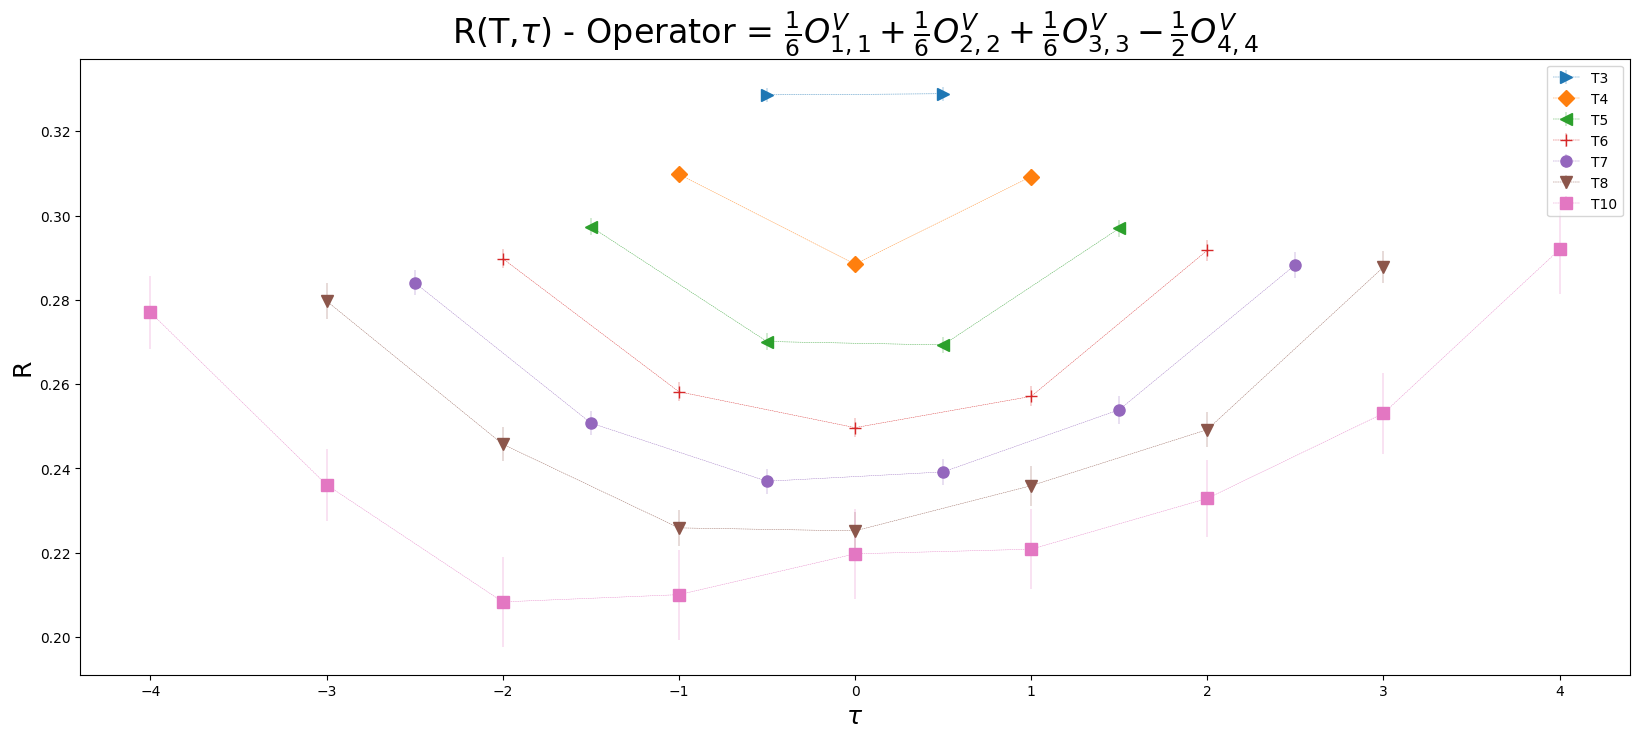

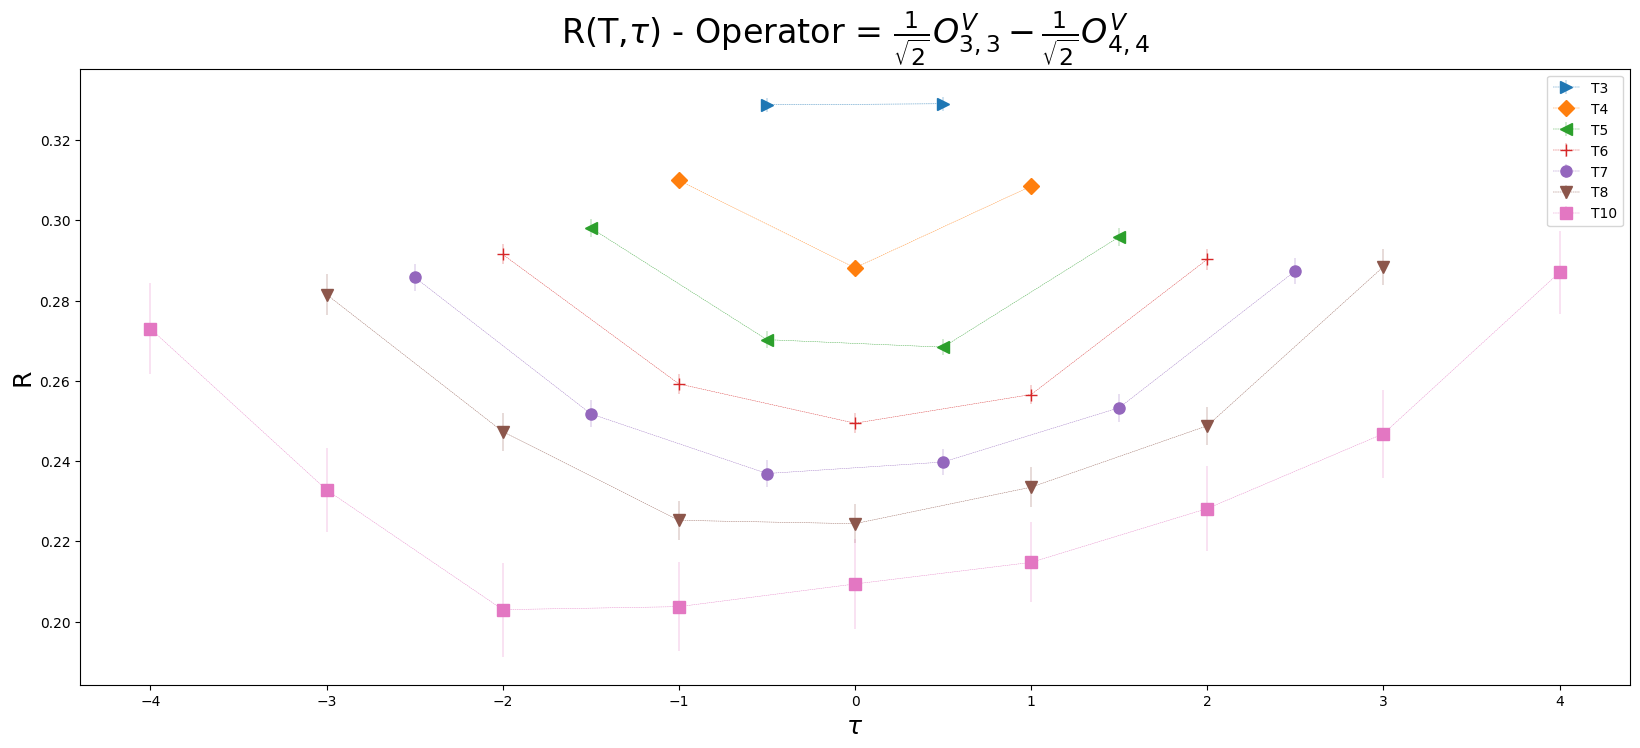

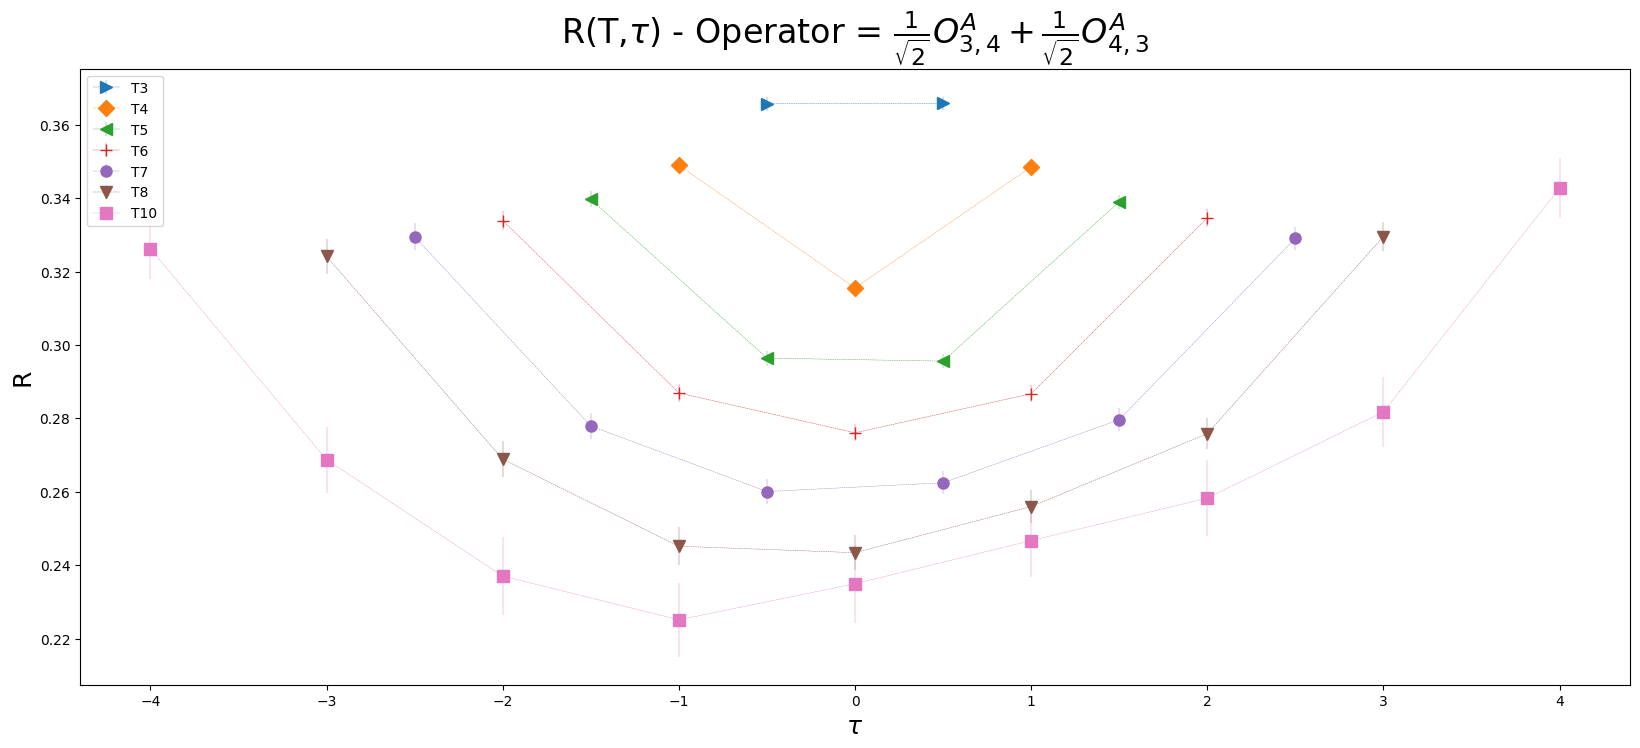

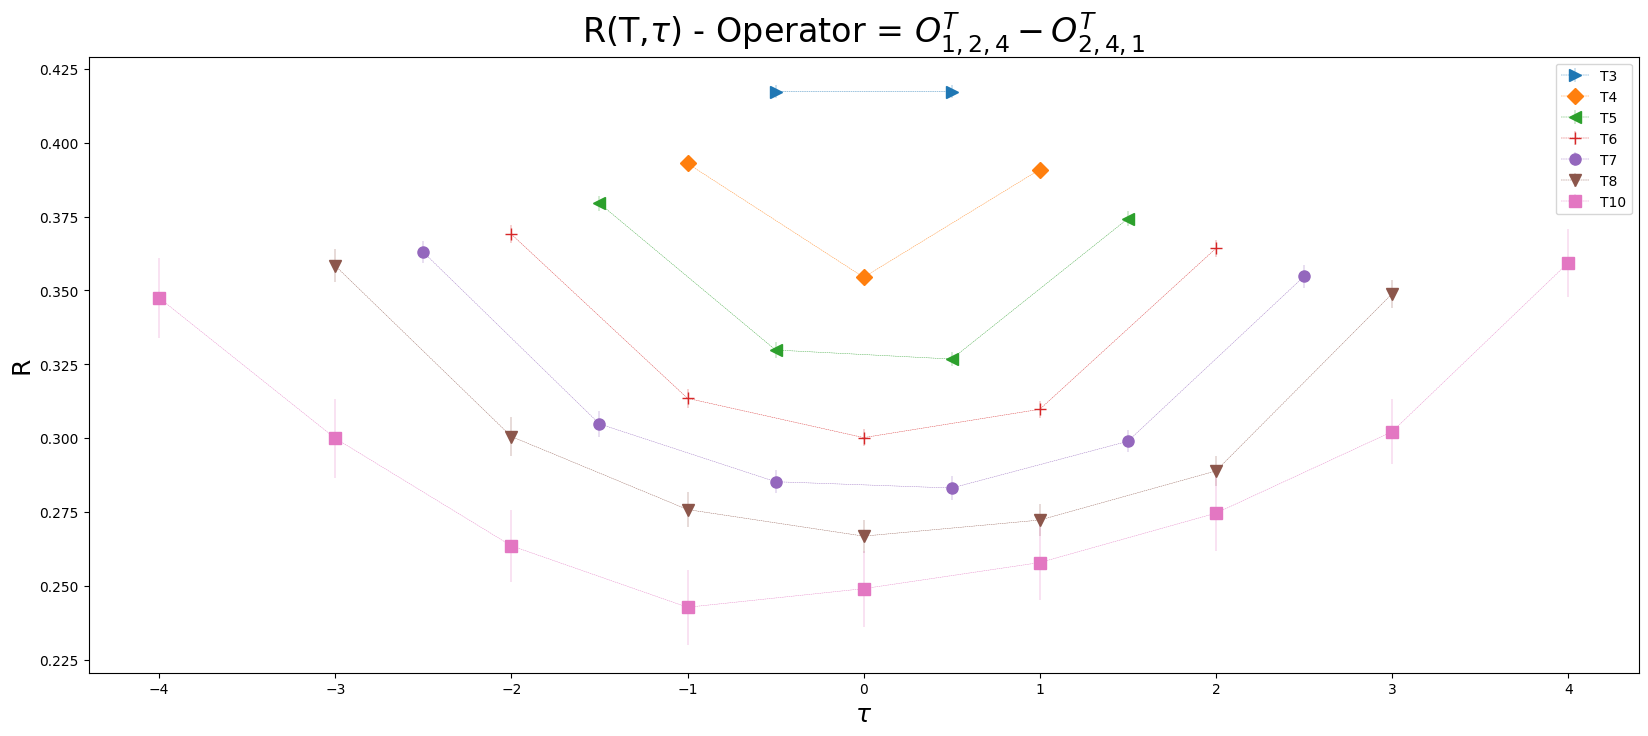

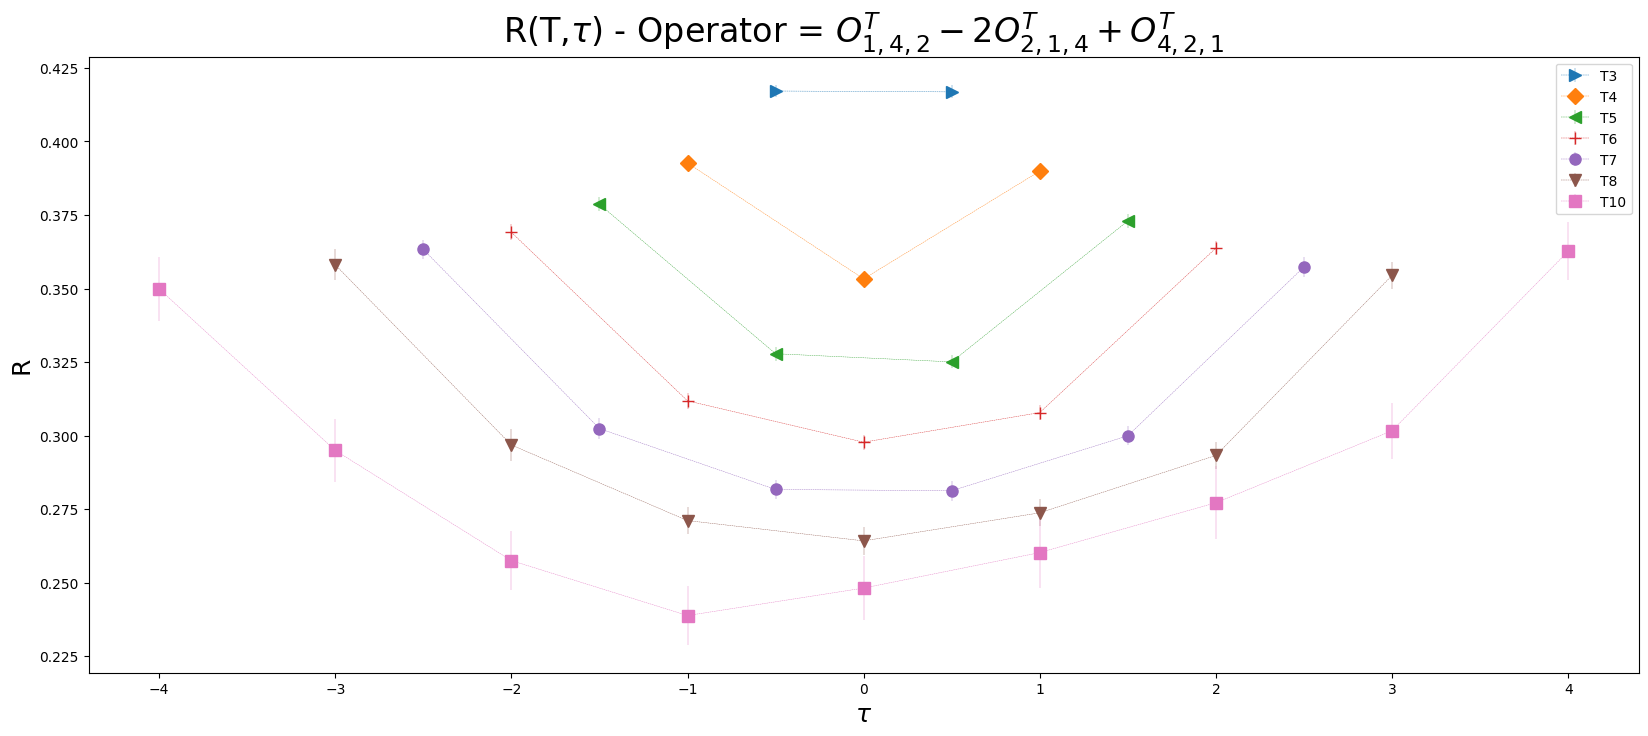

In [8]:
opAnalyzer.remove_T(12)
_ = opAnalyzer.plot_R(rescale=True,save=True)

# $\mathcal{M}$ from $S$

## $S$ plots

In [9]:
Rmean, Rstd, Rcovmat = opAnalyzer.get_R()

"(Nop, NT, max(T)+1 )"
Rmean.shape 

'(Nop, NT, max(T)+1 )'

(5, 7, 11)

In [10]:
Smean, Sstd = opAnalyzer.get_S(tskip=1)

"(Nop, NT)"
Smean.shape

"(Nop, NT)"
Sstd.shape

'(Nop, NT)'

(5, 7)

'(Nop, NT)'

(5, 7)

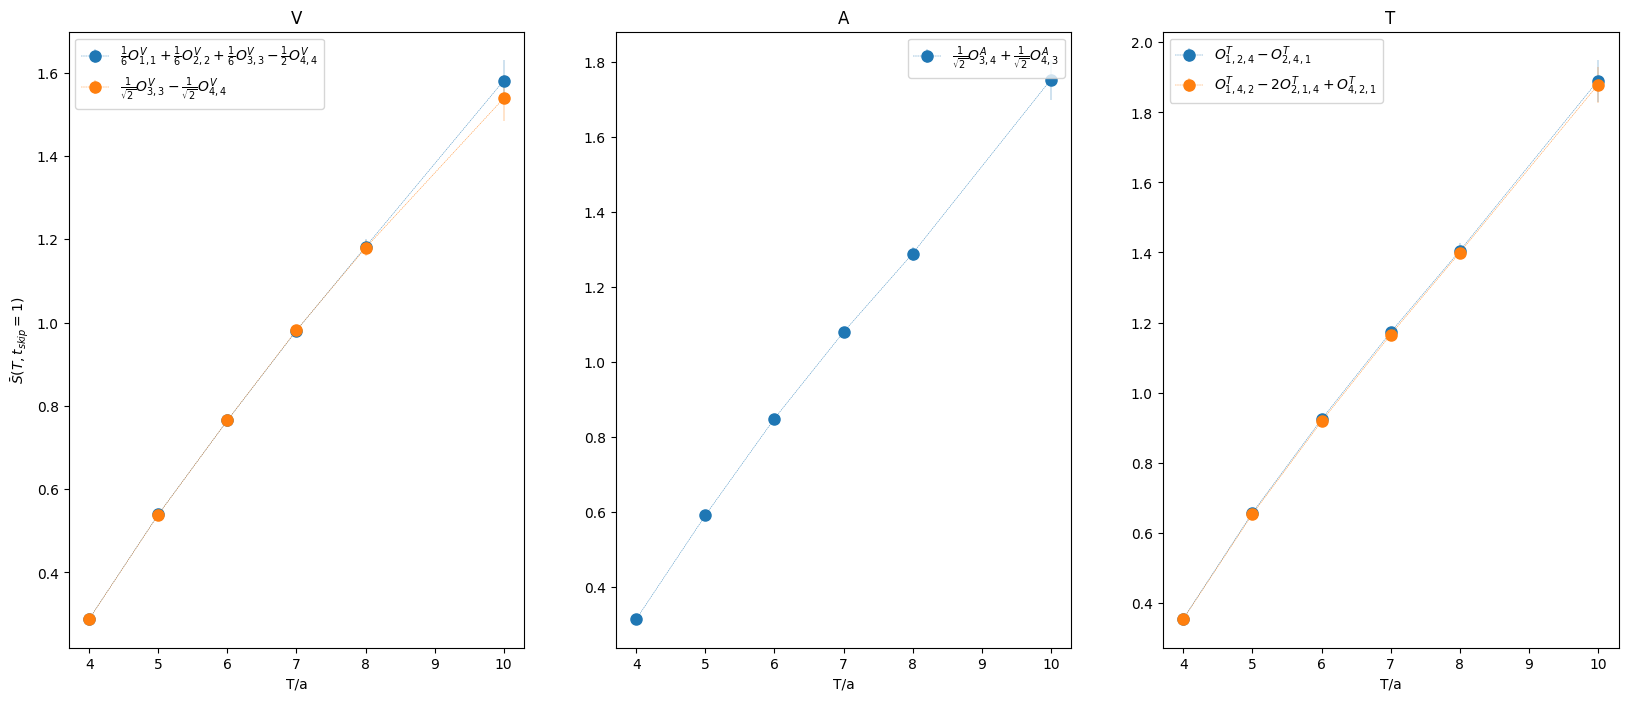

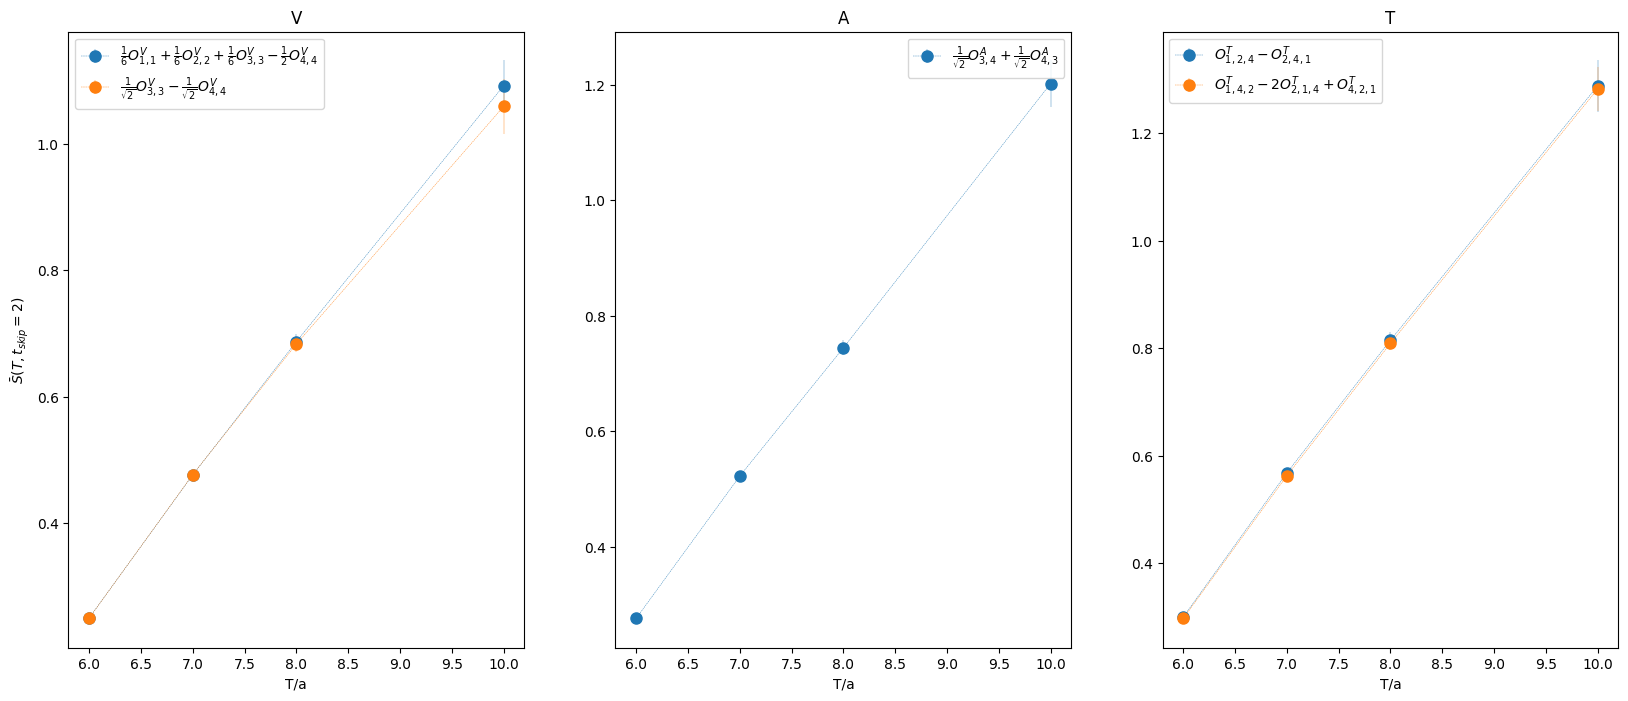

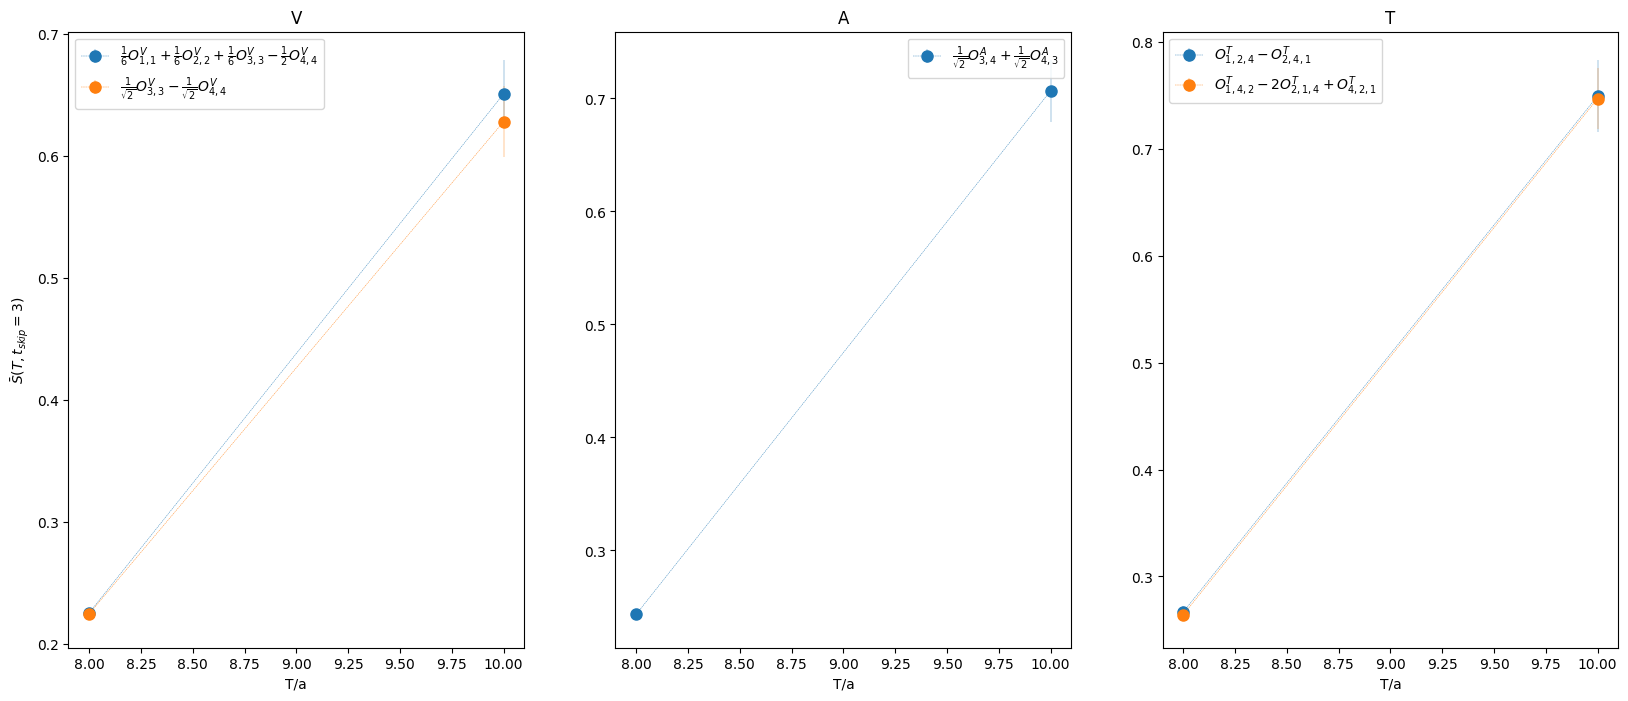

In [11]:
#opAnalyzer.remove_T(3)
_ = opAnalyzer.plot_S(tskip=1, save=True)
_ = opAnalyzer.plot_S(tskip=2, )
_ = opAnalyzer.plot_S(tskip=3, )

## $\mathcal{M}$ from $S$ + ratio Plots

In [12]:
opAnalyzer.remove_T(3,4,5,12)


Available source-skink separation values: [3, 4, 5, 6, 7, 8, 10, 12]
Chosen source-sink separation values: [6, 7, 8, 10]


In [13]:
p2corr = opAnalyzer.get_p2corr()
p3corr = opAnalyzer.get_p3corr()

p3corr.shape

(5, 212, 4, 11)

In [14]:
tskip_list = [1] #[1,2,3]

S_list = np.zeros(shape=(len(opAnalyzer.selected_op), len(opAnalyzer.T_list), len(tskip_list)), # = (Nop, NT, Ntskip)
               dtype=float)

for i_tskip, tskip in enumerate(tskip_list):

    for iT , T in enumerate(opAnalyzer.chosen_T_list):

        S_list[:,iT,i_tskip] = sum_ratios_formula( ratio_formula(p3corr[:,:,iT,:],p2corr, T=T, gauge_axis=1), T, tskip, time_axis=-1)

"(Nop, NT, Ntskip)"
S_list.shape

'(Nop, NT, Ntskip)'

(5, 8, 1)

In [15]:
delta_list = [1,2,3]

MatEle_list = []

for iT, iT_value in enumerate(opAnalyzer.T_list):

    for delta in delta_list:
        
        if iT_value + delta in opAnalyzer.T_list:

            print(f"T={iT_value} - delta={delta}")

            iT_plus_delta = opAnalyzer.T_list.index(iT_value + delta)

            MatEle_list.append( (S_list[:,iT_plus_delta,:] - S_list[:,iT,:])/delta )

MatEle_list = np.asarray( MatEle_list )

"(Nallowed, Nop, Ntskip)"
MatEle_list.shape

T=3 - delta=1
T=3 - delta=2
T=3 - delta=3
T=4 - delta=1
T=4 - delta=2
T=4 - delta=3
T=5 - delta=1
T=5 - delta=2
T=5 - delta=3
T=6 - delta=1
T=6 - delta=2
T=7 - delta=1
T=7 - delta=3
T=8 - delta=2
T=10 - delta=2


'(Nallowed, Nop, Ntskip)'

(15, 5, 1)

In [16]:
#we take mass and energy of g.s.
E0 = opAnalyzer.get_E()
mass = E0

#we set the momentum to 0
p1 = gv.gvar(0,0)
p2 = gv.gvar(0,0)
p3 = gv.gvar(0,0)

In [17]:
for iop in range(len(opAnalyzer.selected_op)):
    op = opAnalyzer.selected_op[iop]
    
    op.X
    
    #MatEle_list[:,iop,:]

   #we compute the kinematic factor
    kin = op.evaluate_K_gvar(m_value=mass, E_value=E0, p1_value=p1, p2_value=p2, p3_value=p3)


    if kin.mean != 0:  
        np.mean(MatEle_list[:,iop,:]) / kin.mean

'V'

np.float64(-0.1391192805396303)

'V'

np.float64(-0.14009249567855156)

'A'

np.float64(-0.15356814319645168)

'T'

np.float64(-0.16718719903442986)

'T'

np.float64(-0.16620557042227138)

In [18]:
matele_fromS = opAnalyzer.MatEle_from_S(tskip_list=[1,2])

#matele_fromS = matele_fromS[:,:2]

In [19]:
matele_fromS

"(Nop, nT-1)"
matele_fromS.shape

array([[0.0580(83), 0.0388(66), 0.045(17)],
       [0.0725(67), 0.050(14), 0.006(39)],
       [-0.0665(76), 0.053(47), 0.053(55)],
       [0.126(12), 0.119(21), 0.009(57)],
       [0.234(14), 0.312(37), 0.081(92)]], dtype=object)

'(Nop, nT-1)'

(5, 3)

In [20]:
iop=0
mat_ele_avg = np.average(matele_fromS[iop], weights= [ele.sdev**(-2) for ele in matele_fromS[iop]] )
mat_ele_avg

0.0462(50)

0.152(15)

0.178(19)

0.169(21)

0.210(22)

0.224(12)

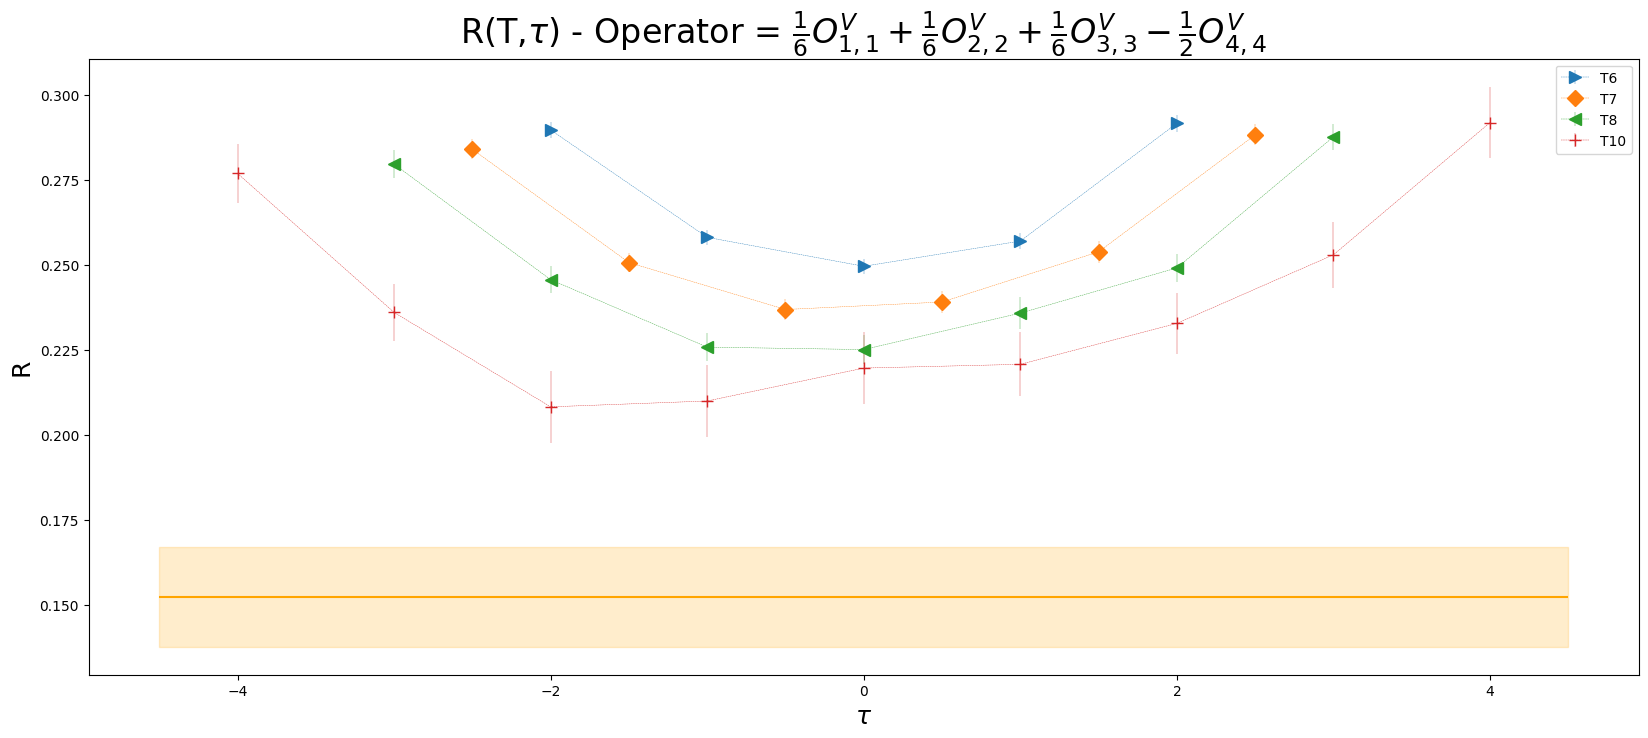

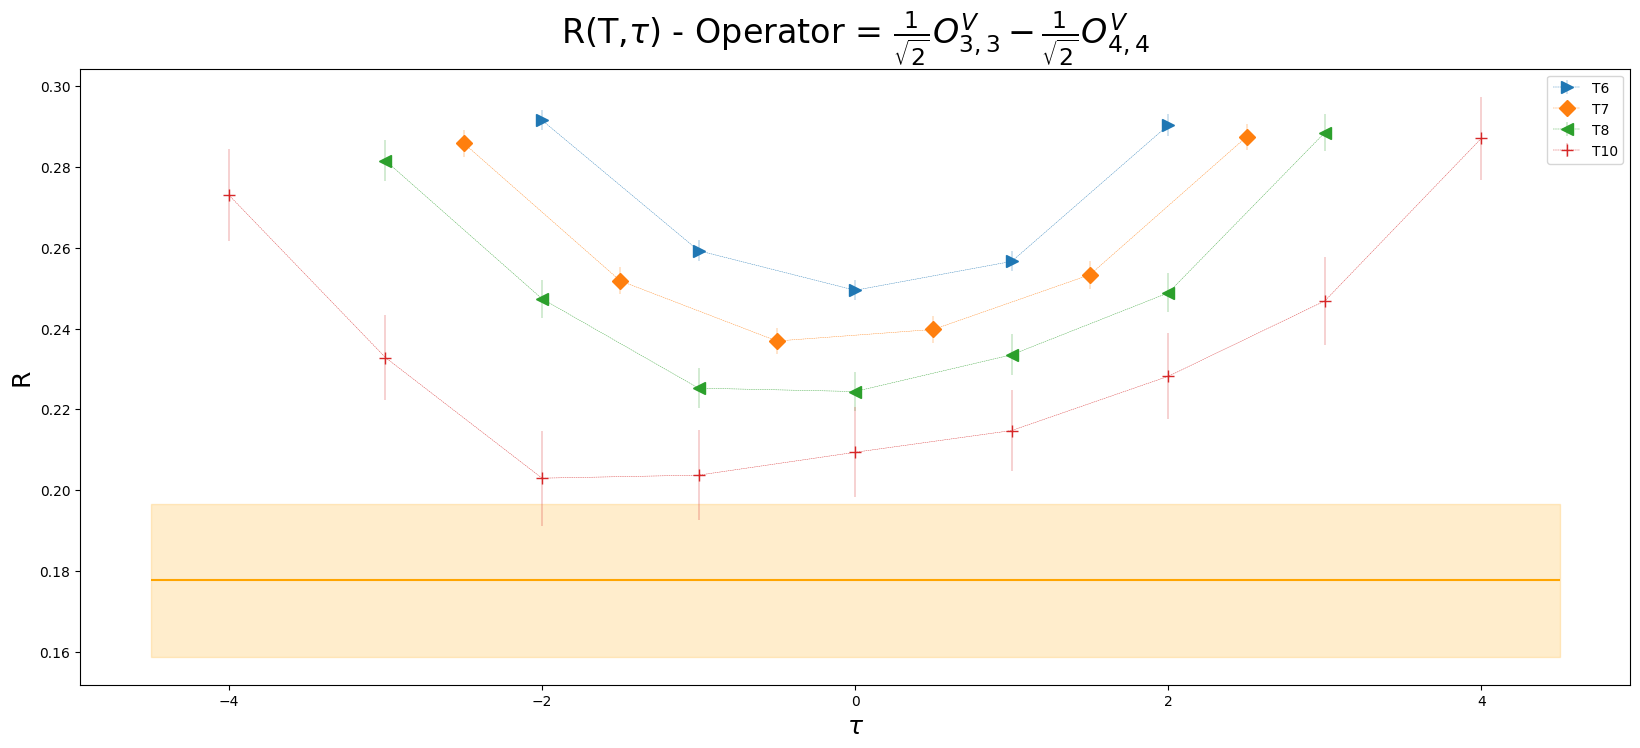

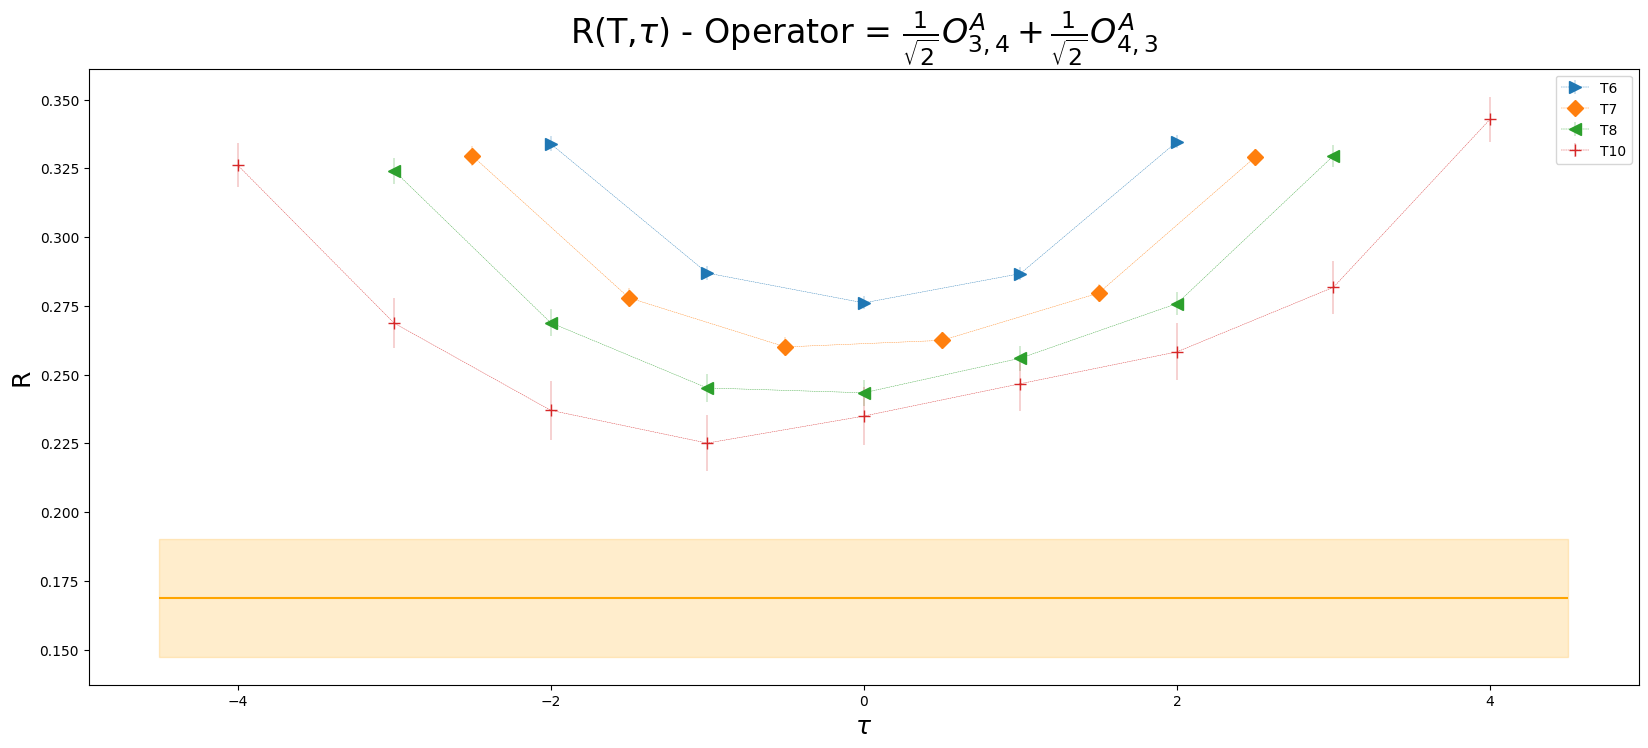

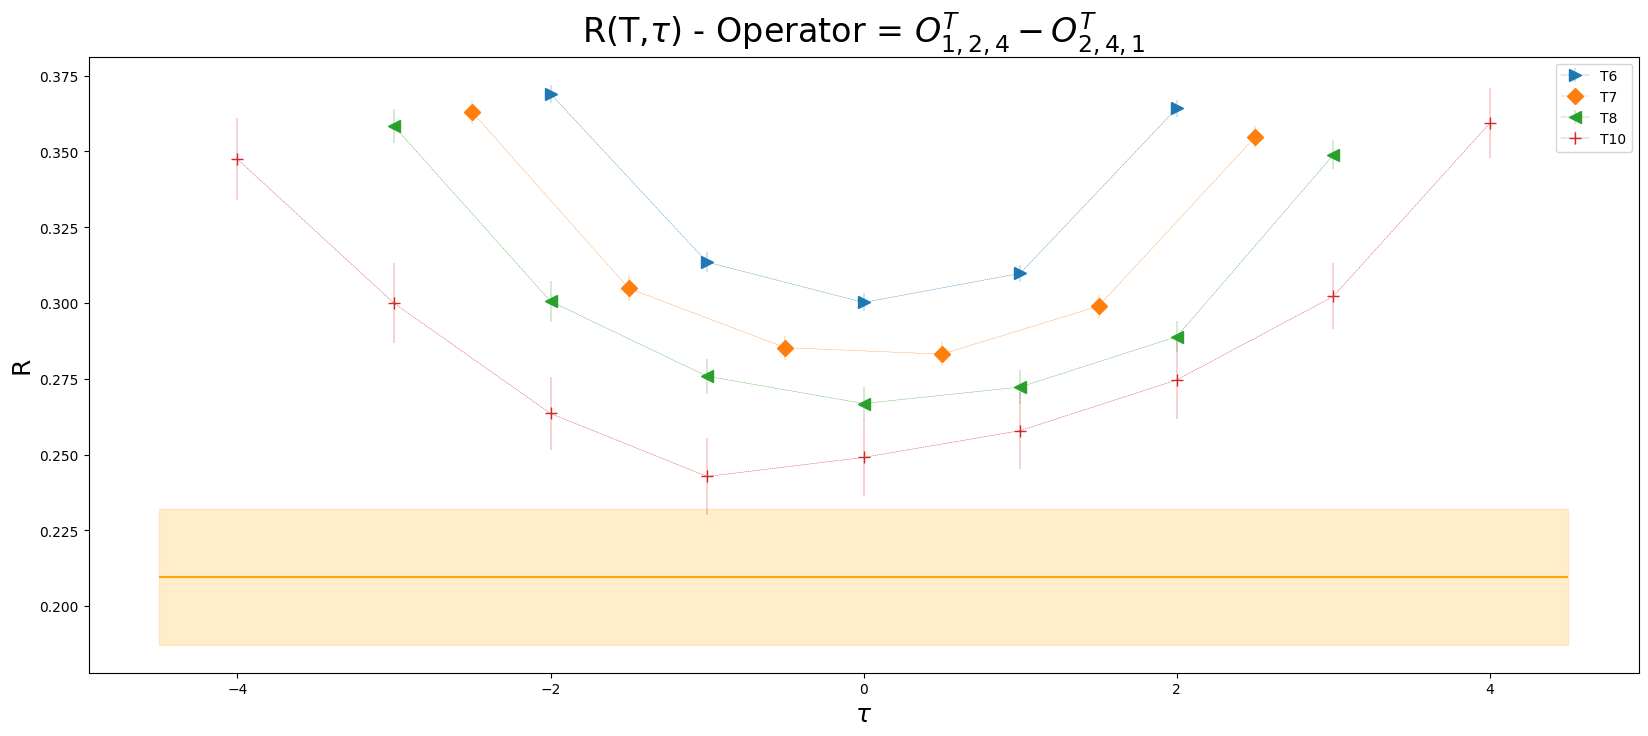

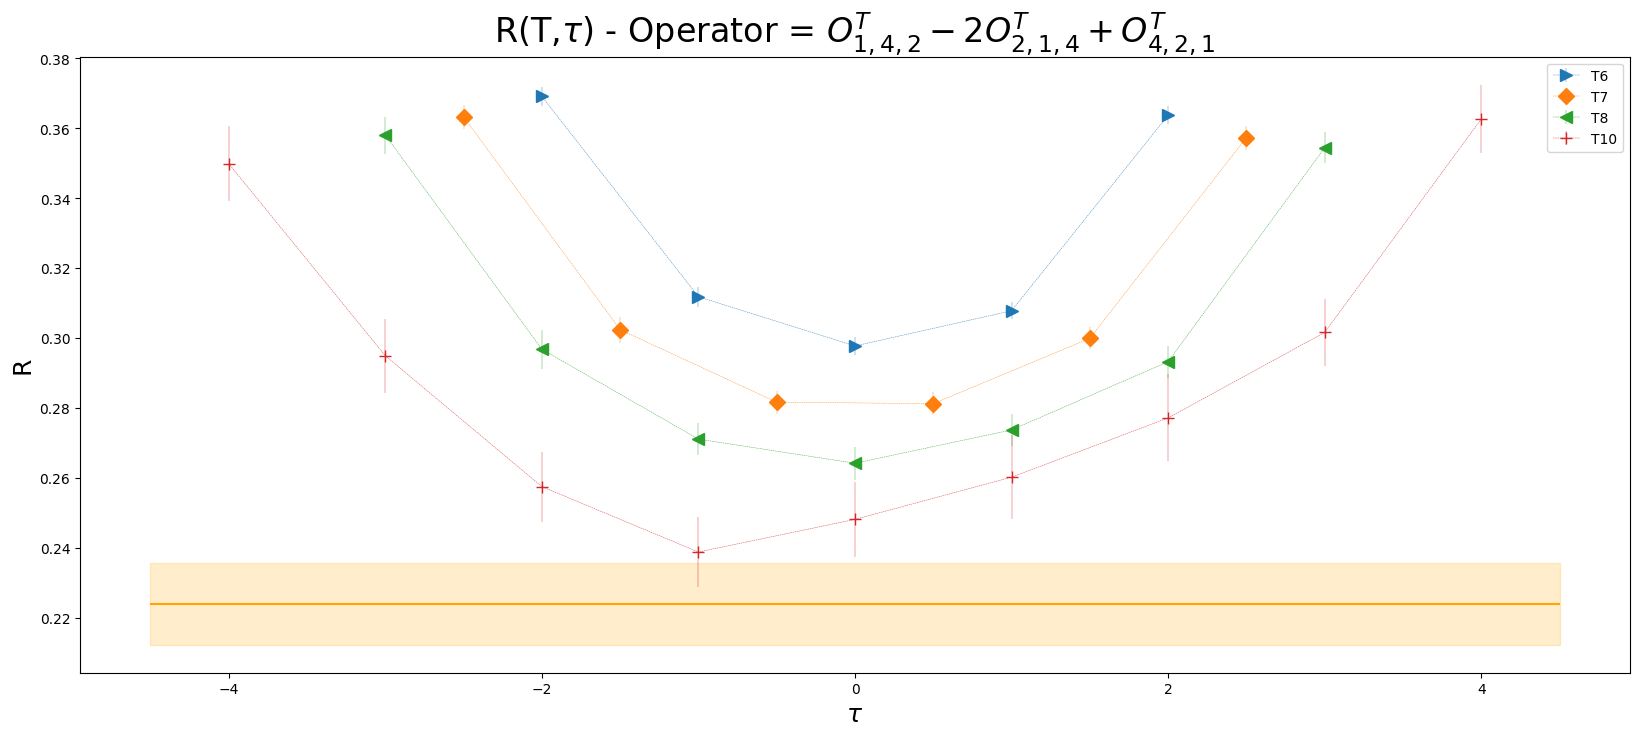

In [21]:
fig_ax_list = opAnalyzer.plot_R(rescale=True,show=False,save=True)

matele_fromS = opAnalyzer.MatEle_from_S(tskip_list=[1])

for iop, fig_ax in enumerate(fig_ax_list):

    fig, ax = fig_ax

    op = opAnalyzer.selected_op[iop]

    #we compute the kinematic factor
    kin = op.evaluate_K_gvar(m_value=mass, E_value=E0, p1_value=p1, p2_value=p2, p3_value=p3)

    

    mat_ele_avg = np.average(matele_fromS[iop], weights= [ele.sdev**(-2) for ele in matele_fromS[iop]] ) / kin
    mat_ele_avg

    T=11

    _ = ax.hlines(mat_ele_avg.mean,-T/2+1,T/2-1,linestyle="solid", color="orange")
    #ax.hlines(mat_ele_avg.mean + mat_ele_avg.std, -T/2+1,T/2,linestyle="solid", color="orange", alpha)
    #ax.hlines(mat_ele_avg.mean - mat_ele_avg.std,-T/2+1,T/2,linestyle="solid", color="orange")
    _ = ax.fill_between(np.arange(-T/2+1,T/2), mat_ele_avg.mean - mat_ele_avg.sdev, mat_ele_avg.mean + mat_ele_avg.sdev, alpha=0.2, color="orange")

plt.show()


# ?????????????

# $\mathcal{M}$ from fit

## First attempts

In [22]:
#np.asarray( [ [ele.sdev**(-2) for ele in matele_fromS[iop]] for iop in range(opAnalyzer.Nop) ] ).shape

In [23]:
#np.average(matele_fromS, weights= axis=1)

In [24]:
#mat_ele_avg_prio = np.average(matele_fromS, weights= [ [ele.sdev**(-2) for ele in matele_fromS[iop]] for iop in range(opAnalyzer.Nop) ], axis=1 )
#mat_ele_avg_prio

In [25]:
#we will use as prior the value extracted from S
matele_fromS = opAnalyzer.MatEle_from_S(tskip_list=[1,2])

#mat_ele_avg = np.average(matele_fromS[iop], weights= [ele.sdev**(-2) for ele in matele_fromS[iop]] )


#mat_ele_prior = np.mean(matele_fromS,axis=1)

mat_ele_prior = np.average(matele_fromS, weights= [ [ele.sdev**(-2) for ele in matele_fromS[iop]] for iop in range(opAnalyzer.Nop) ], axis=1 )

"(Nop, )"
mat_ele_prior.shape

'(Nop, )'

(5,)

In [26]:
#we take mass and energy of g.s.
E0 = opAnalyzer.get_E()
mass = E0

#we set the momentum to 0
p1 = gv.gvar(0,0)
p2 = gv.gvar(0,0)
p3 = gv.gvar(0,0)


for iop, op in enumerate(opAnalyzer.selected_op):
    mat_ele_prior[iop] / op.evaluate_K_gvar(m_value=mass, E_value=E0, p1_value=p1, p2_value=p2, p3_value=p3)

0.162(17)

0.166(15)

0.153(18)

0.212(18)

0.211(12)

In [27]:
#first we take the value of R
Rmean, Rstd, Rcovmat = opAnalyzer.get_R()

In [28]:
Rmean.shape
Rcovmat.shape

(5, 4, 11)

(5, 4, 11, 11)

In [29]:
#we search for the plateau for each op and for each T



#for iT,T in enumerate(opAnalyzer.T_list):
#
#    #T
#
#    for iop,op in enumerate(opAnalyzer.selected_op):
#            
#        #we compute the kinematic factor
#        kin = op.evaluate_K_gvar(m_value=mass, E_value=E0, p1_value=p1, p2_value=p2, p3_value=p3)
#
#        if kin.mean ==0:
#            continue
#
#        
#            
#
#        start_plateau, end_plateau = plateau_search(Rmean[iop,iT,:T+1 ], Rcovmat[iop,iT,:T+1 , :T+1 ], only_sig=False, chi2_treshold=1.0)
#        #start_plateau, end_plateau



allowedT = np.empty(shape=(opAnalyzer.Nop,), dtype=list)
plateau_dict = {}

for iop,op in enumerate(opAnalyzer.selected_op):

    allowedT[iop] = []

    for iT,T in enumerate(opAnalyzer.chosen_T_list):

        start_plateau, end_plateau = plateau_search(Rmean[iop,iT,:T+1 ], Rcovmat[iop,iT,:T+1 , :T+1 ], only_sig=False, chi2_treshold=1.5)

        plateau_dict[(iop,iT)] = start_plateau, end_plateau

        for tau in range(start_plateau,end_plateau):
            allowedT[iop].append( (T,tau) )

allowedT[0]

[(6, 3), (7, 3), (7, 4), (8, 3), (8, 4), (10, 3), (10, 4), (10, 5), (10, 6)]

In [30]:
fit2p = opAnalyzer.fit_2pcorr(show=False,save=False)

In [31]:
fit2p_parms = fit2p.model_average()

dE1 = gv.gvar(fit2p_parms['est']['dE1'], fit2p_parms['err']['dE1'])

dE1

E0 = gv.gvar(fit2p_parms['est']['E0'], fit2p_parms['err']['E0'])

E0

0.08226(27)

0.5687(26)

In [32]:
a = 0.1163 #we cheat
hc = 197.327
dE1 *hc /a

E0 *hc /a

139.57(47)

964.9(4.4)

In [33]:
opAnalyzer.get_p3corr().shape

(5, 212, 4, 11)

In [34]:
#abscissa = np.ones(shape=Rmean[0].shape)
#
#abscissa = np.cumsum(abscissa, axis=1) -1
#
#abscissa.shape

#abscissa = [ [(T,tau) for tau in range(0,T+1)] for T in opAnalyzer.T_list ]
#abscissa = np.asarray( [e for l in abscissa for e in l] )


#abscissa.shape


In [35]:
#
#def jackknife_resamples(in_array_list: np.ndarray|list[np.ndarray], observable, jack_axis_list:int|list[int|None]=0, binsize:int=1,first_conf:int=0, last_conf:int|None=None) -> list[np.ndarray]:
#    """
#    Function returning the jackknife resamples of the given observablem that can be computed with the given inputs.
#
#    Input:
#        - in_array_list: input array to be jackknifed, or a list containing such arrays
#        - observable: function taking as input an array of the same shape of in_array (i.e. an observable that should be computed over it), and giving as output an array with the jackknife axis (i.e. conf axis) removed
#        - jack_axis_list: the axis over which perform the jacknife analysis (from a physics p.o.v. the axis with the configurations) (or a list with such axis for every input array)
#        - binsize: binning of the jackknife procedure
#        - first_conf: index of the first configuration taken into account while performing the jackknife procedure
#        - last_conf: index of the last configuration taken into account while performing the jackknife procedure (if not specified then the last available configuration is used)
#
#    Output:
#        - list with [mean, std, cov] where mean and std are np array with same the same shape as the input one minus the jackknife dimension, and the cov has one extra time dimension (the new time dimension is now the last one)
#    """
#
#    #we make a check on the input to asses that the number of input_array, jackknife axes and time_axes is consistend
#    if type(in_array_list) is list and (type(jack_axis_list) is not list or len(in_array_list)!=len(jack_axis_list) ):
#        raise ValueError("The input array is a list, hence also the jackknife axis should be a list and have the same lenght, but that is not the case")
#    
#    #if the given input is just one array and not a list of arrays, then we put it in a list
#    if type(in_array_list) is not list:
#        in_array_list = [in_array_list]
#        jack_axis_list = [jack_axis_list]
#
#    #we set last conf to its default value
#    if last_conf is None:
#        last_conf = np.shape(in_array_list[0])[jack_axis_list[0]]
#
#    #step 1: creation of the jackknife resamples (we create a jack resample for input array in the list)
#    jack_resamples_list = [ np.asarray( [np.delete(in_array, list(range(iconf,min(iconf+binsize,last_conf))) ,axis=jack_axis_list[i]) for iconf in range(first_conf,last_conf,binsize)] ) for i,in_array in enumerate(in_array_list)]#shape = (nresamp,) + shape(in_array) (with nconf -> nconf-binsize)
#
#    #the number of resamples is len(jack_resmaples[0]) or also
#    #nresamp = int((last_conf-first_conf)/binsize)
#    nresamp = np.shape(jack_resamples_list[0])[0] #the 0th axis now is the resample axis, (and axis has nconf-1 conf in the standard case (binsize=1 ecc.) )
#
#    #step 2; for each resample we compute the observable of interest
#    #we use the resampled input array to compute the observable we want, and we have nresamp of them
#    obs_resamp = np.asarray( [observable( *[jack_resamples[i] for jack_resamples in jack_resamples_list] ) for i in range(nresamp) ] )                                                                          #shape = (nresamp,) + output_shape
#
#    return obs_resamp

In [36]:
#class ratio_func_form:
#
#    def __init__(self,r1:bool=True,r2:bool=True,r3:bool=False):
#        self.r1:bool=r1
#        self.r2:bool=r2
#        self.r3:bool=r3
#        
#    def __call__(self, t:tuple[int,int], parms:dict):
#
#        #we grep the input
#        T = t[:,0]
#        tau = t[:,1]
#        MatEle = parms["M"]
#        R1 = parms["R1"]
#        R2 = parms["R2"]
#        R3 = parms["R3"]
#        dE = parms["dE"]
#
#        out = MatEle
#
#        if self.r1:
#            out += R1 * np.exp(-T/2*dE)*np.cosh( (T/2 - tau) * dE)
#        if self.r2:
#            out += R2 * np.exp(-T*dE)
#
#        if self.r3:
#            out /= (1 + R3 * np.exp(-T*dE))
#
#        return out

In [37]:
p3 = opAnalyzer.get_p3corr()
p2 = opAnalyzer.get_p2corr()
#
#iop = 0
#
#ratio = []
#
#for iT,T in enumerate(opAnalyzer.T_list):
#    ratio.append( ratio_formula(p3, p2, T, gauge_axis=1)[iop,iT,:T+1] )
#
##ratio = [e for l in ratio for e in l]

In [38]:
#np.asarray( [e for l in [ ratio_formula(p3, p2, T, gauge_axis=1)[iop,iT,:T+1] for iT,T in enumerate(opAnalyzer.T_list) ] for e in l] )

In [39]:
#ratio_res2 = [ jackknife_resamples([p3,p2], lambda x,y: np.asarray( [e for l in [ ratio_formula(x, y, T, gauge_axis=1)[iop,iT, plateau_dict[(iop,iT)][0] : plateau_dict[(iop,iT)][1] ] for iT,T in enumerate(opAnalyzer.T_list) ] for e in l] ), jack_axis_list=[1,0] ) for iop in range(opAnalyzer.Nop) ] 
#
#len(ratio_res2)
#ratio_res2[1].shape

In [40]:
iop = 0


#ratio_res = jackknife_resamples([p3,p2], lambda x,y: np.asarray( [e for l in [ ratio_formula(x, y, T, gauge_axis=1)[iop,iT, :T+1] for iT,T in enumerate(opAnalyzer.T_list) ] for e in l] ), jack_axis_list=[1,0] )
ratio_res = jackknife_resamples([p3,p2], lambda x,y: np.asarray( [e for l in [ ratio_formula(x, y, T, gauge_axis=1)[iop,iT, plateau_dict[(iop,iT)][0] : plateau_dict[(iop,iT)][1] ] for iT,T in enumerate(opAnalyzer.chosen_T_list) ] for e in l] ), jack_axis_list=[1,0] )

np.shape(ratio_res)


nres = ratio_res.shape[0]

abscissa = np.asarray( allowedT[iop] )
abscissa.shape

(212, 9)

(9, 2)

In [41]:
#len(ratio)
#len(abscissa)

In [42]:
prior = gv.BufferDict()

prior["dE"] = gv.gvar(fit2p_parms['est']['dE1'], fit2p_parms['err']['dE1'])

prior["M"] = mat_ele_prior[iop]

prior["R1"] = gv.gvar(0,10)
prior["R2"] = gv.gvar(0,10)
prior["R3"] = gv.gvar(0,10)

prior

BufferDict({'dE': 0.08226(27), 'M': 0.0462(50), 'R1': 0 ± 10, 'R2': 0 ± 10, 'R3': 0 ± 10})

In [43]:
#we do the fit
fit_res = CA.fit(

    abscissa                = abscissa,
    
    ordinate_est            = np.mean(ratio_res, axis = 0),
    ordinate_std            = np.sqrt((nres-1)/nres) * np.std (ratio_res, axis = 0),
    ordinate_cov            = (nres-1)/nres * np.cov (ratio_res, rowvar=False),
    
    resample_ordinate_est   = ratio_res,
    resample_ordinate_std   = np.sqrt((nres-1)/nres) * np.std (ratio_res, axis = 0),
    resample_ordinate_cov   = (nres-1)/nres * np.cov (ratio_res, rowvar=False),

    # fit strategy, default: only uncorrelated central value fit:
    central_value_fit            = True,
    central_value_fit_correlated = True,

    resample_fit                 = True,
    resample_fit_correlated      = True,
    
    resample_fit_resample_prior  = False,
    resample_type               = "bst",#"jkn",

    # args for lsqfit:
    model   = ratio_func_form(r1=True,r2=True,r3=False),
    prior   = prior,
    p0      = None,

    svdcut  = None,
    maxiter = 10_000,
)

In [44]:
fit_res

FitResult[ ([6 3],[10  6]), resample:bst]:
  𝜒²/dof [dof] = 254 [9]
  AIC = 2.3e+03 
    - dE: 0.082988(30)  [0.08226(27)]
    - M: -0.0360(24)  [0.0462(50)]
    - R1: 0.1665(63)  [0 ± 10]
    - R2: -0.0373(42)  [0 ± 10]
    - R3: 0 ± 0  [0 ± 10]

In [45]:
fit_state = CA.FitState()

fit_state.append(fit_res)

In [46]:
fit_state.model_average()

{'est': {'dE': np.float64(0.08298843558810584),
  'M': np.float64(-0.03599430610701795),
  'R1': np.float64(0.1665390287430813),
  'R2': np.float64(-0.03726332663602283),
  'R3': np.float64(0.0)},
 'err': {'dE': np.float64(3.03063316346596e-05),
  'M': np.float64(0.002382562971706084),
  'R1': np.float64(0.006273047080104603),
  'R2': np.float64(0.004178227971085863),
  'R3': np.float64(0.0)},
 'res': {'dE': array([0.08298425, 0.08295427, 0.08298032, 0.08298959, 0.08301123,
         0.08296122, 0.08299612, 0.08295627, 0.08293888, 0.08297201,
         0.08301502, 0.08297896, 0.08300768, 0.08298969, 0.08300843,
         0.08300148, 0.08304537, 0.08295638, 0.08300863, 0.0829377 ,
         0.08299091, 0.08298423, 0.08303101, 0.08295873, 0.08296099,
         0.08295346, 0.08297495, 0.08292143, 0.08301136, 0.08299745,
         0.08297116, 0.08300574, 0.08296647, 0.08300903, 0.0830238 ,
         0.08302408, 0.08299074, 0.08297782, 0.08294994, 0.08301325,
         0.08307645, 0.08292948, 0.083

In [47]:
fit_par_res = fit_res.best_fit_param

In [48]:
deltaE = fit_par_res['dE']

deltaE *hc / a

140.81(46)

In [49]:
mat_ele_prior

array([0.0462(50), 0.0667(59), -0.0613(74), 0.121(10), 0.241(13)],
      dtype=object)

In [50]:
#opAnalyzer.fit_2pcorr(show=True,save=True,zoom=5)

## Systematic Fit + plot

In [51]:
opAnalyzer.remove_T(12)


Available source-skink separation values: [3, 4, 5, 6, 7, 8, 10, 12]
Chosen source-sink separation values: [3, 4, 5, 6, 7, 8, 10]


In [52]:
#first we take the value of R
Rmean, Rstd, Rcovmat = opAnalyzer.get_R()

In [53]:
#ratio_list = [ [e for l in  [Rcovmat[iop,iT, plateau_dict[(iop,iT)][0] : plateau_dict[(iop,iT)][1],  plateau_dict[(iop,iT)][0] : plateau_dict[(iop,iT)][1]] for iT,T in enumerate(opAnalyzer.T_list) ] for e in l]  for iop in range(opAnalyzer.Nop)]
#len( ratio_list[1] )

In [54]:
#ratio_list = [ np.asarray([e for l in  [Rstd[iop,iT, plateau_dict[(iop,iT)][0] : plateau_dict[(iop,iT)][1]] for iT,T in enumerate(opAnalyzer.T_list) ] for e in l] ) for iop in range(opAnalyzer.Nop)]
#ratio_list[1].shape

In [55]:
allowedT = np.empty(shape=(opAnalyzer.Nop,), dtype=list)
plateau_dict = {}

for iop,op in enumerate(opAnalyzer.selected_op):

    allowedT[iop] = []

    for iT,T in enumerate(opAnalyzer.chosen_T_list):

        start_plateau, end_plateau = plateau_search(Rmean[iop,iT,:T+1 ], Rcovmat[iop,iT,:T+1 , :T+1 ], only_sig=False, chi2_treshold=2.0)

        plateau_dict[(iop,iT)] = start_plateau, end_plateau

        for tau in range(start_plateau,end_plateau):
            allowedT[iop].append( (T,tau) )

In [56]:
fit_state_list =opAnalyzer.fit_ratio(chi2_treshold=2.0, fit_doubt_factor=3,
                                     central_value_fit=True, central_value_fit_correlated=True, resample_fit=True, resample_fit_correlated=True) #TO DO: make to function return the fit state and then debug the plot from there

In [57]:
#start_plateau, end_plateau = plateau_dict[(iop,iT)]
#
#times = np.arange(start_plateau, end_plateau)
#times
#
#model = ratio_func_form(r1=True,r2=True,r3=True)
#
#
#ok = np.asarray( [(T,tau) for tau in times] )
#ok
#model(ok, post_dict)

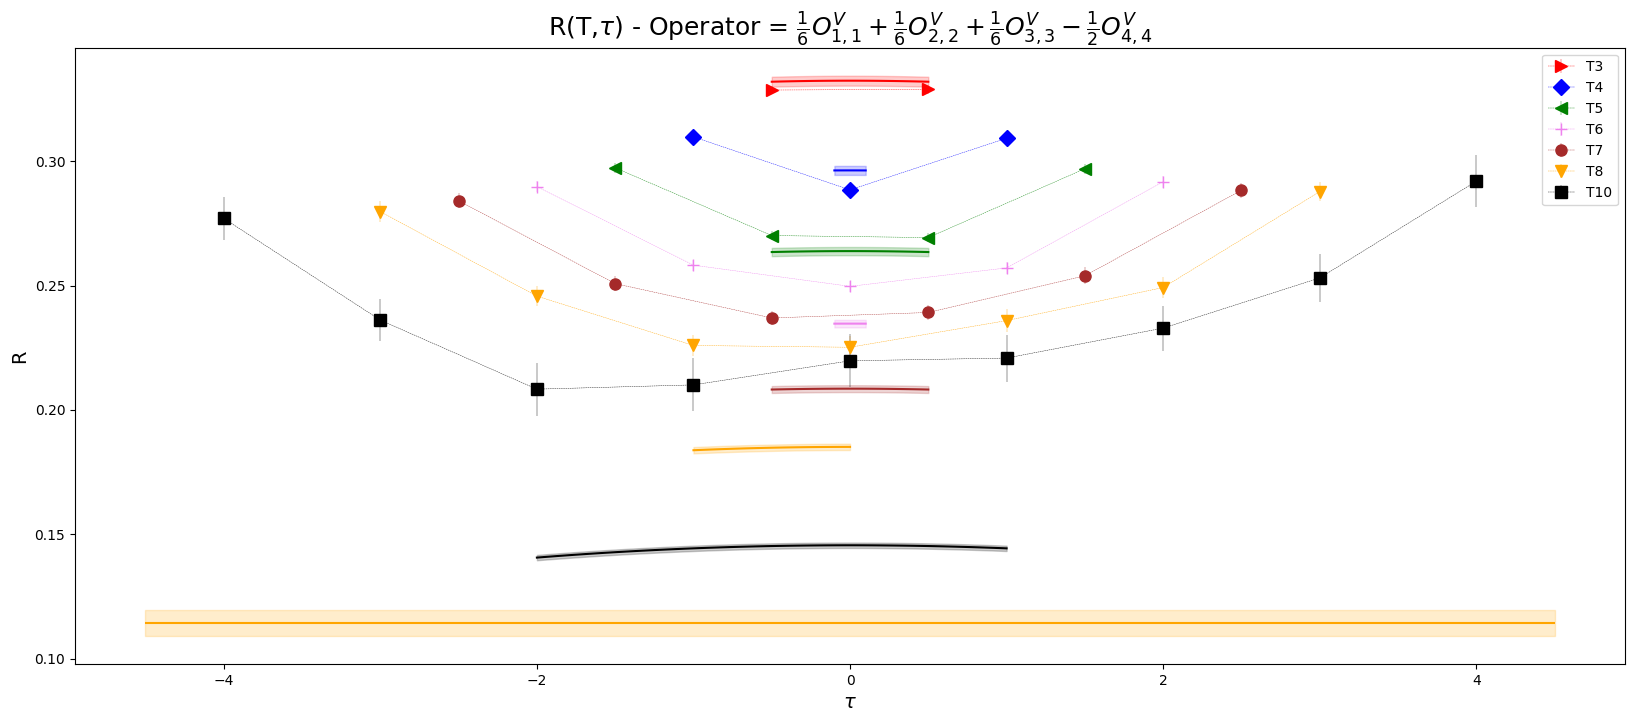

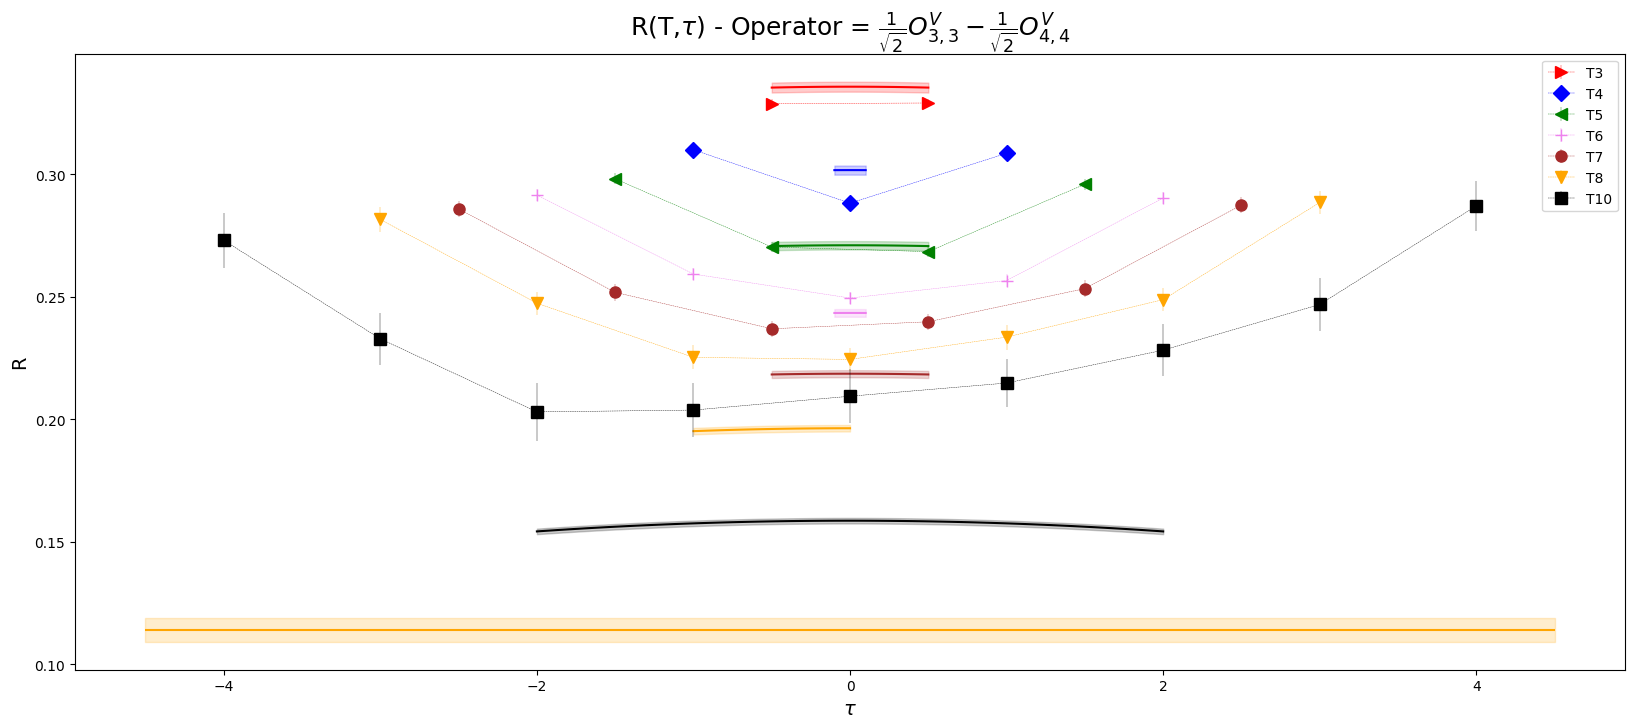

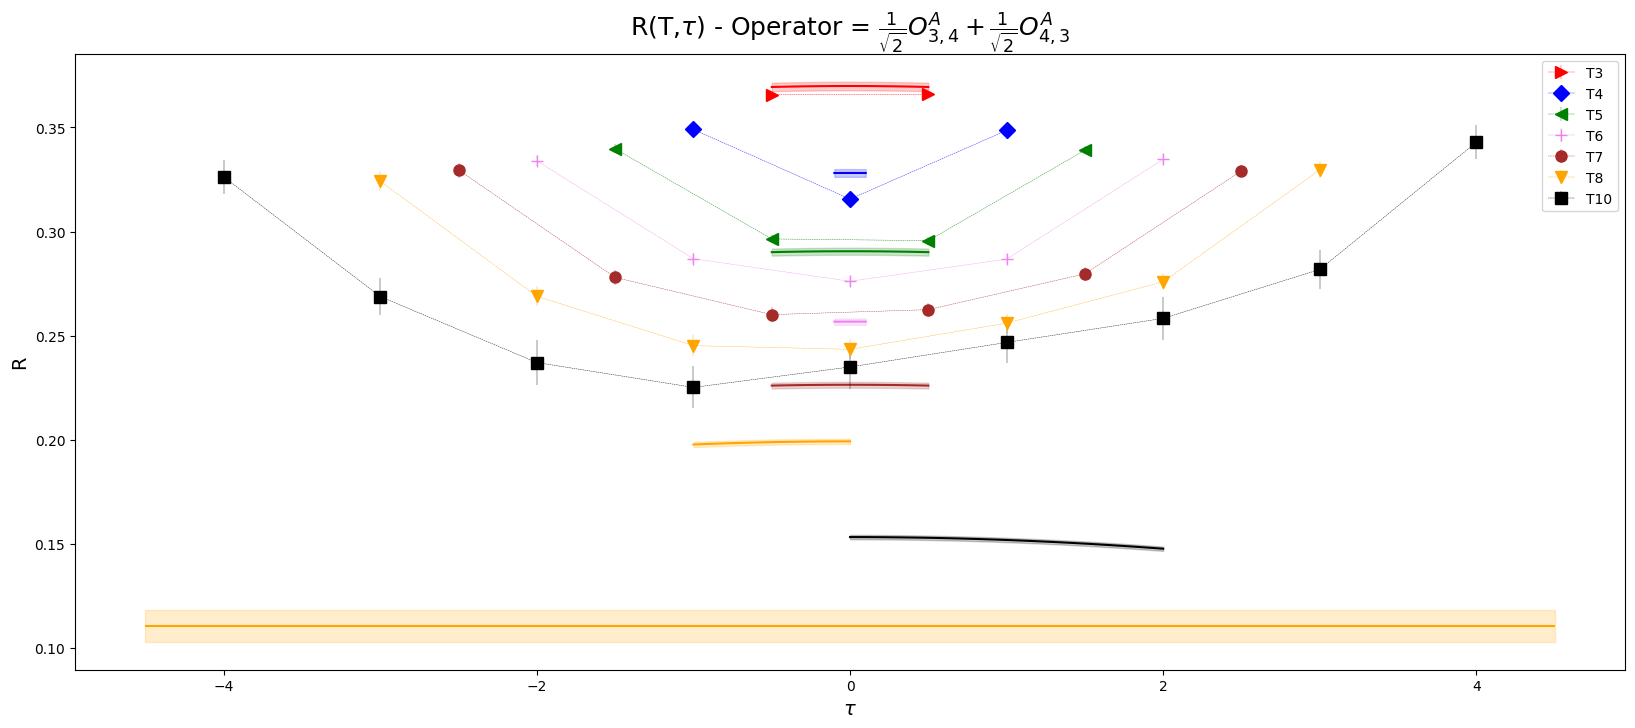

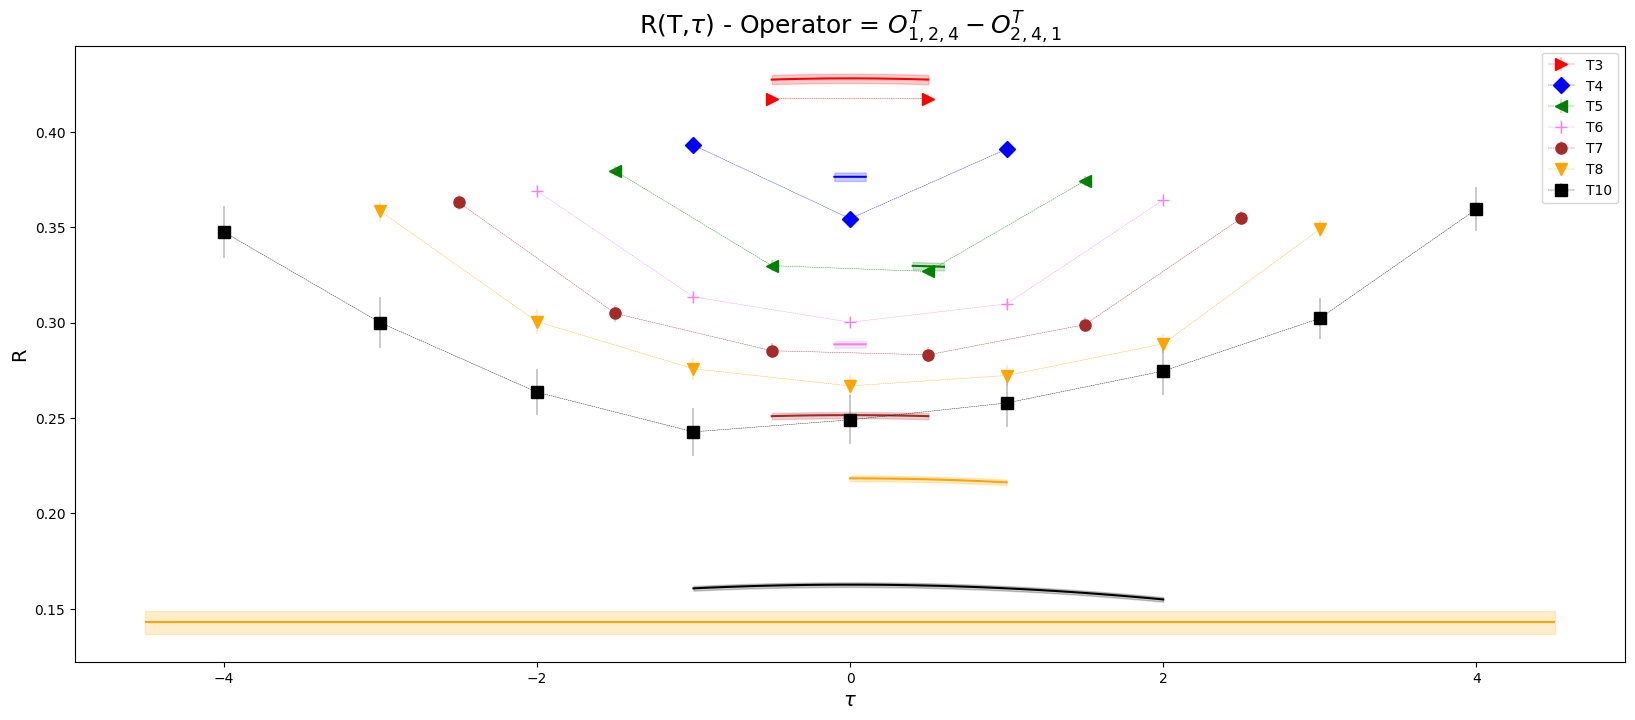

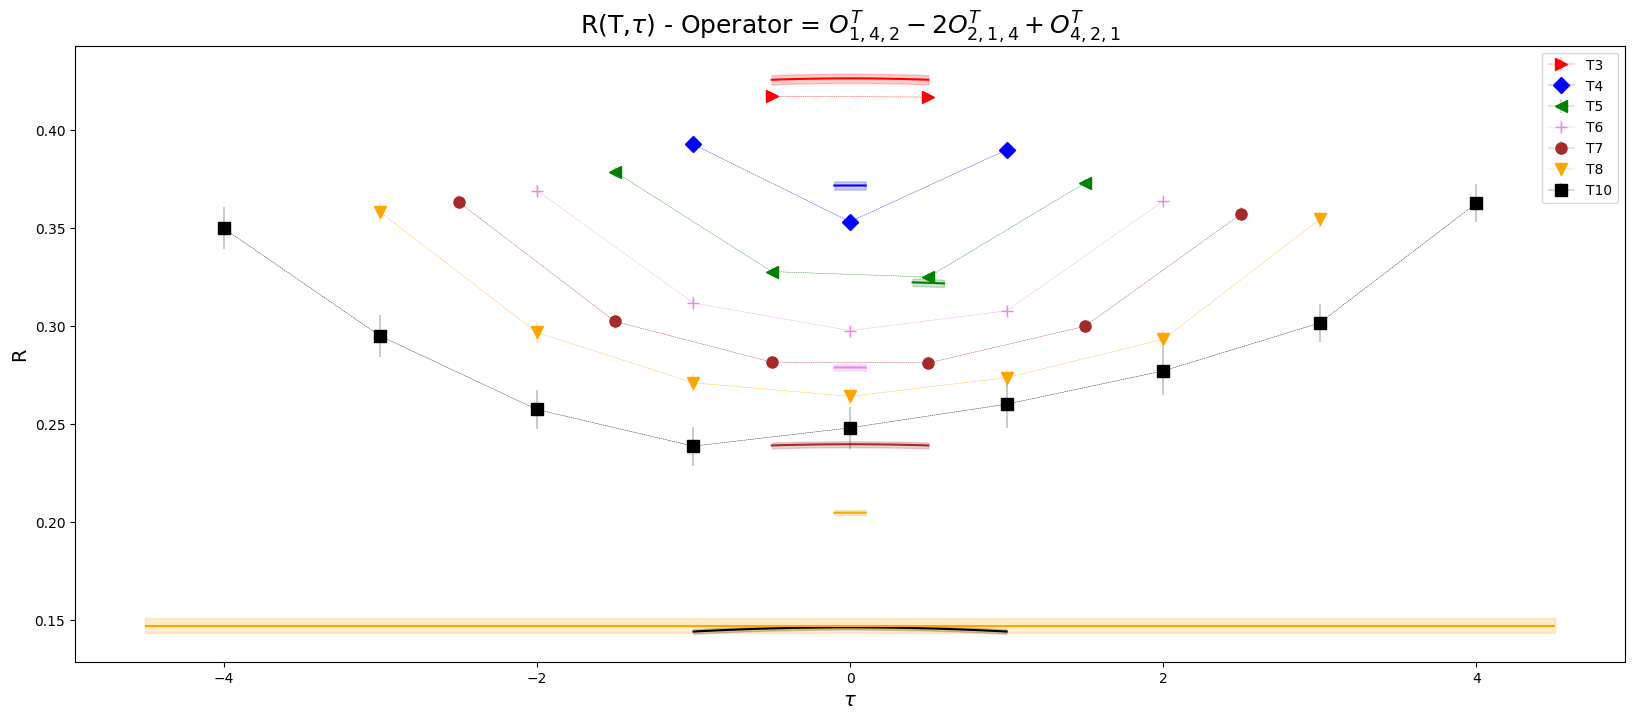

In [58]:
#we first fetch R using the dedicate method
Rmean, Rstd, Rcovmat = opAnalyzer.get_R()

#wewe instantiate the output list where we will store all the figure and axes
#fig_ax_list:list[tuple[Figure, Any]]  = []
#fig_ax_list = self.plot_R(show=False,save=True) #TO DO: adjust save - show condition in plot_R

figsize = (20,8)
fontsize_title =18
fontsize_x = 14
fontsize_y = 14
markersize = 8
rescale = True

colors = ['red','blue', 'green', 'violet', 'brown', 'orange','black']

matele_fromS = opAnalyzer.MatEle_from_S(tskip_list=[1])#,2])

#loop over selected operators (for each we make a plot)
for iop,op in enumerate(opAnalyzer.selected_op):
    

    
    
    
    #fit avg results
    avg_result = fit_state_list[iop].model_average()
    dE = gv.gvar(avg_result["est"]['dE'], avg_result["err"]['dE'])
    matele = gv.gvar(avg_result["est"]['M'], avg_result["err"]['M'])
    R1 = gv.gvar(avg_result["est"]['R1'], avg_result["err"]['R1'])
    R2 = gv.gvar(avg_result["est"]['R2'], avg_result["err"]['R2'])
    R3 = gv.gvar(avg_result["est"]['R3'], avg_result["err"]['R3'])

    post_dict = {key:gv.gvar(avg_result["est"][key], avg_result["err"][key]) for key in avg_result["est"].keys()}

    
    #instantiate figure
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=figsize)

    #we add figure and axes to the output list
    #fig_ax_list.append((fig,ax))

    #we cycle on the markers
    marker = it.cycle(('>', 'D', '<', '+', 'o', 'v', 's', '*', '.', ',')) 

    #we loop over T and each time we add a graph to the plot
    for iT, T in enumerate(opAnalyzer.chosen_T_list):

        times = np.arange(-T/2+1,T/2)

        start_plateau, end_plateau = plateau_dict[(iop,iT)]
        #start_plateau, end_plateau

        #times = np.arange(1, T)

        #we grep the interesting part of the array and we ignore the padding along the last axis
        ratio = Rmean[iop,iT,1:T]
        ratio_err = Rstd[iop,iT,1:T]

        #we discard the endpoints
        r = ratio#[1:-1]
        r_err = ratio_err#[1:-1]

        #we put R into a gvar variable
        r_gvar = gv.gvar(r,r_err)

        #we rescale to the kfactor #TO DO: check the kinematics factors
        if rescale:
            #we take mass and energy of g.s.
            E0 = opAnalyzer.get_E()
            mass = E0

            #we set the momentum to 0
            p1 = gv.gvar(0,0)
            p2 = gv.gvar(0,0)
            p3 = gv.gvar(0,0)

            #we compute the kinematic factor
            kin = op.evaluate_K_gvar(m_value=mass, E_value=E0, p1_value=p1, p2_value=p2, p3_value=p3)

            #ratio /= kin if kin!=0 else 1
            
            r_gvar /= kin if kin!=0 else 1

        #we recast everything into np array
        r = np.asarray( [c.mean for c in r_gvar])
        r_err = np.asarray( [c.sdev for c in r_gvar])


        #_=plt.plot(times,r,marker = 'o', linewidth = 0.3, linestyle='dashed',label=i)
        #ax.errorbar(times, r,yerr=ratio_err, marker = 'o', linewidth = 0.3, linestyle='dashed',label=f"T{T}")
        _ = ax.errorbar(times, r,yerr=r_err, marker = next(marker), markersize = markersize, linewidth = 0.3, linestyle='dashed',label=f"T{T}", color= colors[iT])
        _ = ax.legend()

        _ = ax.set_title(r"R(T,$\tau$) - Operator = ${}$".format(op),fontsize=fontsize_title)
        _ = ax.set_xlabel(r"$\tau$", fontsize=fontsize_x)
        _ = ax.set_ylabel('R', fontsize=fontsize_y)

        model = ratio_func_form(r1=True,r2=True,r3=True)

        eps = 0.1
        times = np.linspace(start_plateau, end_plateau-1,100) if end_plateau-start_plateau>1 else np.linspace(start_plateau-eps, end_plateau-1 + eps,100)
        times_plot = np.linspace(start_plateau-T/2, end_plateau-T/2-1,100) if end_plateau-start_plateau>1 else np.linspace(start_plateau-T/2-eps, end_plateau-T/2-1 + eps,100)
        x = times_plot

        model_y = model( np.asarray( [(T,tau) for tau in times] ) ,post_dict)
        
        if rescale:
            model_y /= kin if kin.mean!=0 else 1
            #y /=  kin.mean if kin.mean!=0 else 1
            #yps /=  kin.mean if kin.mean!=0 else 1
            #yms /=  kin.mean if kin.mean!=0 else 1


        y = np.asarray( [c.mean for c in  model_y] )

        yps = np.asarray( [c.mean + c.sdev for c in  model_y] )
        yms = np.asarray( [c.mean - c.sdev for c in  model_y] )


        _ = ax.plot(x,  y, color= colors[iT])
        _ = ax.fill_between(x,yms,yps, alpha = 0.2, color= colors[iT])


    mat_ele_avg = np.average(matele_fromS[iop], weights= [ele.sdev**(-2) for ele in matele_fromS[iop]] ) #/ kin
    #mat_ele_avg = matele_fromS[iop][2]

    T=11

    if rescale:
       mat_ele_avg /=  kin if kin.mean!=0 else 1

    _ = ax.hlines(mat_ele_avg.mean, -T/2+1,T/2-1,linestyle="solid", color="orange")
    #ax.hlines(mat_ele_avg.mean + mat_ele_avg.std, -T/2+1,T/2,linestyle="solid", color="orange", alpha)
    #ax.hlines(mat_ele_avg.mean - mat_ele_avg.std,-T/2+1,T/2,linestyle="solid", color="orange")
    _ = ax.fill_between(np.arange(-T/2+1,T/2), mat_ele_avg.mean - mat_ele_avg.sdev, mat_ele_avg.mean + mat_ele_avg.sdev, alpha=0.2, color="orange")


    plt.show()

In [59]:
#abscissa = np.empty(shape=(self.Nop,), dtype=list)
abscissa_list = []

#we take the values of R
Rmean, Rstd, Rcovmat = opAnalyzer.get_R()

#we instantiate the dict where we will store the range of the plateaux used to define the abscissa
plateau_dict = {}

for iop,op in enumerate(opAnalyzer.selected_op):

    #abscissa[iop] = []
    tmp_a = []

    for iT,T in enumerate(opAnalyzer.chosen_T_list):

        start_plateau, end_plateau = plateau_search(Rmean[iop,iT,:T+1 ], Rcovmat[iop,iT,:T+1 , :T+1 ], only_sig=False, chi2_treshold=2.0)

        plateau_dict[(iop,iT)] = start_plateau, end_plateau

        for tau in range(start_plateau,end_plateau):
            #abscissa[iop].append( (T,tau) )
            tmp_a.append( (T,tau) )

    abscissa_list.append( np.asarray(tmp_a) )

#the number of resamples is given by
nres = abscissa_list[0].shape

nres

(14, 2)

In [60]:
ok = abscissa_list[0]
T = ok[:,0]
tau = ok[:,1]

T
tau

array([ 3,  3,  4,  5,  5,  6,  7,  7,  8,  8, 10, 10, 10, 10])

array([1, 2, 2, 2, 3, 3, 3, 4, 3, 4, 3, 4, 5, 6])

In [61]:
(T/2 - tau)

array([ 0.5, -0.5,  0. ,  0.5, -0.5,  0. ,  0.5, -0.5,  1. ,  0. ,  2. ,
        1. ,  0. , -1. ])

In [62]:
p3corr = opAnalyzer.get_p3corr() #shape = (Nop, nconf, nT, maxT+1)
p2corr = opAnalyzer.get_p2corr()

In [63]:
ratio_resamples_list = [ jackknife_resamples([p3corr,p2corr], lambda x,y: np.asarray( [e for l in [ ratio_formula(x, y, T, gauge_axis=1)[iop,iT, plateau_dict[(iop,iT)][0] : plateau_dict[(iop,iT)][1] ] for iT,T in enumerate(opAnalyzer.chosen_T_list) ] for e in l] ), jack_axis_list=[1,0] ) for iop in range(opAnalyzer.Nop) ]
ratio_resamples_list[0].shape

(212, 14)

In [64]:
ratio_resamples_list[0].mean()
ratio_resamples_list[0].std() * np.sqrt( ratio_resamples_list[0].shape[0])

np.float64(0.07151774825827677)

np.float64(0.16115303579831694)

In [65]:
from moments_toolkit import jackknife

In [66]:
#ratio_list, = [ jackknife([p3corr,p2corr], lambda x,y: np.asarray( [e for l in [ ratio_formula(x, y, T, gauge_axis=1)[iop,iT, plateau_dict[(iop,iT)][0] : plateau_dict[(iop,iT)][1] ] for iT,T in enumerate(opAnalyzer.T_list) ] for e in l] ), jack_axis_list=[1,0] ) for iop in range(opAnalyzer.Nop) ]


In [67]:
#r,rstd,rocv = ratio_list[0]
#
#r.shape

In [68]:
Rmean, Rstd, Rcovmat = opAnalyzer.get_R()



# First moment estimate

In [69]:
matele_list = []

for iop in range(opAnalyzer.Nop):
    avg_result = fit_state_list[iop].model_average()
    dE = gv.gvar(avg_result["est"]['dE'], avg_result["err"]['dE'])
    matele = gv.gvar(avg_result["est"]['M'], avg_result["err"]['M'])
    matele_list.append(matele)

matele_list

matele_list = np.asarray(matele_list)

[0.0324470(48), 0.0463724(51), -0.044384(13), 0.0840521(98), 0.1682421(78)]

In [70]:
fit_state_list[0]

FitState(fit_results=[FitResult[ ([3 1],[10  6]), resample:bst]:
  𝜒²/dof [dof] = 78.1 [14]
  AIC = 1.08e+03 
    - dE: 0.08242928(49)  [0.08226(27)]
    - M: 0.0324470(48)  [0.0324(15)]
    - R1: -0.15614(29)  [0.5(1.0)]
    - R2: 0.25617(33)  [0 ± 1.0]
    - R3: 0 ± 0  [0 ± 1.0]
, FitResult[ ([3 1],[10  6]), resample:bst]:
  𝜒²/dof [dof] = 249 [14]
  AIC = 3.47e+03 
    - dE: 0.0834366(19)  [0.08226(27)]
    - M: 0.002530(39)  [0.0324(15)]
    - R1: 0.106693(46)  [0.5(1.0)]
    - R2: 0 ± 0  [0 ± 1.0]
    - R3: 0 ± 0  [0 ± 1.0]
], keys_all=['dE', 'M', 'R1', 'R2', 'R3'], param_avg={'est': {'dE': np.float64(0.08242928284983964), 'M': np.float64(0.03244696600125855), 'R1': np.float64(-0.15614190930332353), 'R2': np.float64(0.2561658563878629), 'R3': np.float64(0.0)}, 'err': {'dE': np.float64(4.918586147576798e-07), 'M': np.float64(4.829489284947202e-06), 'R1': np.float64(0.000294121605934445), 'R2': np.float64(0.00032802405395359333), 'R3': np.float64(0.0)}, 'res': {'dE': array([0.082429

In [71]:
fit_state_list[0].model_average()

{'est': {'dE': np.float64(0.08242928284983964),
  'M': np.float64(0.03244696600125855),
  'R1': np.float64(-0.15614190930332353),
  'R2': np.float64(0.2561658563878629),
  'R3': np.float64(0.0)},
 'err': {'dE': np.float64(4.918586147576798e-07),
  'M': np.float64(4.829489284947202e-06),
  'R1': np.float64(0.000294121605934445),
  'R2': np.float64(0.00032802405395359333),
  'R3': np.float64(0.0)},
 'res': {'dE': array([0.08242933, 0.08242925, 0.08242926, 0.08242948, 0.08242992,
         0.08242928, 0.08242864, 0.08242869, 0.08242911, 0.08242981,
         0.08242976, 0.08242933, 0.08242906, 0.08242986, 0.0824292 ,
         0.08242924, 0.08242772, 0.08243003, 0.08242968, 0.08242941,
         0.08242959, 0.08242917, 0.08242918, 0.08242981, 0.08243002,
         0.08242926, 0.08242911, 0.08243011, 0.08242919, 0.08242916,
         0.08242921, 0.08242849, 0.0824291 , 0.08242797, 0.08242897,
         0.08243014, 0.08242917, 0.08242955, 0.08242927, 0.08242917,
         0.08242887, 0.08243   , 0.

In [72]:
ratio_list = [ jackknife([p3corr,p2corr], lambda x,y: np.asarray( [e for l in [ ratio_formula(x, y, T, gauge_axis=1)[iop,iT, plateau_dict[(iop,iT)][0] : plateau_dict[(iop,iT)][1] ] for iT,T in enumerate(opAnalyzer.chosen_T_list) ] for e in l] ), jack_axis_list=[1,0] ) for iop in range(opAnalyzer.Nop) ]


In [73]:
iop=1

ratio, ratio_std, ratio_cov = ratio_list[iop]

ratio.shape
ratio_std.shape
ratio_cov.shape

(15,)

(15,)

(15, 15)

In [74]:
sum( [v[1]-v[0] for k,v in plateau_dict.items() if k[0]==iop] )

15

In [75]:
#fit2p_state = opAnalyzer.fit_2pcorr(save=False,show=False)

In [76]:
#model_avg_2p = fit2p_state.model_average()
#
#E0 = gv.gvar( model_avg_2p["est"]["E0"], model_avg_2p["err"]["E0"])
#
#E0 *hc / a

In [77]:
#from sympy import lambdify

In [78]:
#from kinematic_data import E, p1,p2,p3,mN, I

In [79]:
#lambdify([E, mN, p1,p2,p3], 1j*op.K)(E0, E0, gv.gvar(0,0), gv.gvar(0,0), gv.gvar(0,0))

In [80]:
#we take mass and energy of g.s.
E0 = opAnalyzer.get_E()
mass = E0

#we set the momentum to 0
p1 = gv.gvar(0,0)
p2 = gv.gvar(0,0)
p3 = gv.gvar(0,0)

In [81]:
K_list = []

for iop,op in enumerate(opAnalyzer.selected_op):

    kin = op.evaluate_K_gvar(m_value=mass, E_value=E0, p1_value=p1, p2_value=p2, p3_value=p3)

    K_list.append(kin)

   
K_list


K_list = np.asarray( K_list)

[0.2843(13), 0.4021(19), -0.4021(19), 0.5687(26), 1.1373(52)]

In [82]:
moments = matele_list/ K_list
moments

array([0.11412(53), 0.11532(53), 0.11038(51), 0.14780(68), 0.14793(68)],
      dtype=object)

In [83]:
from moments_toolkit import sum_ratios_formula, ratio_formula
T_list = opAnalyzer.chosen_T_list
delta_list = [1,2,3]
tskip_list = [1,2]

iop = 0

#we first take the correlators we need to compute everything
p2_corr = opAnalyzer.get_p2corr() #shape = (Nconf, latticeT)
p3_corr = opAnalyzer.get_p3corr() #shape = (Nop, Nconf, NT, maxT+1)

p3_corr = p3_corr[iop]

## First the calculation of the the summed ratios using the formula

#we start by instantiatinh the list with the summed ratios we are going to use, shape = (NT, Ntskip)
S_list = np.zeros(shape=(len(T_list), len(tskip_list)),  dtype=float)

#loop over selected tau skip
for i_tskip, tskip in enumerate(tskip_list):

    #loop over available source sink seprations T
    for iT , T in enumerate(T_list):

        #we compute the summed ratio with the formula
        S_list[iT,i_tskip] = sum_ratios_formula( ratio_formula(p3_corr[:,iT,:], p2_corr, T=T, gauge_axis=1), T, tskip, time_axis=-1)

## Then the computation of all the matrix elements (one for each available compination of delta+T, and one for each tau skip)

#we instantiate the list with the allowed matrix elements as empty
mat_ele_array = np.zeros(shape=(len(T_list),), dtype=float) #shape = (nT,)

#we loop over the values of tau skip
for itskip,tskip in enumerate(tskip_list):

    #for the given value of tau skip we compute the treshold value of T 
    T_treshold = 1 + 2*tskip #because we want to have (T+1) -2 -2tau_skip > 0

    #we initialize the value of the cut to 0
    iT_cut = 0

    #we loop over all the smaller values of T to find the one from which we should start cutting the data
    for T in range(T_treshold, T_list[0]-1,-1):

        #when (and if) we find the biggest value that can be removed, we remove from it onward and stop the loop
        if T in T_list:

            #the index from where we will cut is
            iT_cut = T_list.index(T) + 1

            #we break the loop
            break

    #we loop over the source-sink separations T, from the cut on
    for iT, T in enumerate(T_list[iT_cut:]):

        #we instantiate a tmp list where we store all the matrix elements related to the given T
        tmp_mat_ele_list = []

        #we loopv over the delta we want to use in the analysis (delta is the separation we use to look at the slope)
        for delta in delta_list:
            
            #a combination T,delta is allowed only if their sum is in the available Ts
            if T + delta in T_list:

                #we check what is the index of the T we have to consider
                iT_plus_delta = T_list.index(T + delta)

                #we compute the matrix element as the slope of the summed ratio function
                tmp_mat_ele_list.append( (S_list[iT_plus_delta,itskip] - S_list[iT+iT_cut,itskip])/delta )

                tskip, T, delta, (S_list[iT_plus_delta,itskip] - S_list[iT+iT_cut,itskip])/delta, S_list[iT+iT_cut,itskip]

        #for the given T we extract a value of the matrix element, and we just take a simple unnweighted average over all the values of tskip and the allowed values of T+delta
        mat_ele_array[iT+iT_cut] = np.mean(tmp_mat_ele_list) if len(tmp_mat_ele_list)!=0 else 0 #TO DO: check if something better can be done than the plain unweighted average

(1, 4, 1, np.float64(0.025538022634890165), np.float64(0.018046868397822793))

(1, 4, 2, np.float64(0.03210073208652803), np.float64(0.018046868397822793))

(1, 4, 3, np.float64(0.03679846307659602), np.float64(0.018046868397822793))

(1, 5, 1, np.float64(0.038663441538165894), np.float64(0.04358489103271296))

(1, 5, 2, np.float64(0.04242868329744895), np.float64(0.04358489103271296))

(1, 5, 3, np.float64(0.04738889123953537), np.float64(0.04358489103271296))

(1, 6, 1, np.float64(0.046193925056732005), np.float64(0.08224833257087885))

(1, 6, 2, np.float64(0.05175161609022011), np.float64(0.08224833257087885))

(1, 7, 1, np.float64(0.057309307123708214), np.float64(0.12844225762761086))

(1, 7, 3, np.float64(0.07129069082780537), np.float64(0.12844225762761086))

(1, 8, 2, np.float64(0.07828138267985395), np.float64(0.18575156475131907))

(2, 6, 1, np.float64(0.03861413887029387), np.float64(0.024816165135711398))

(2, 6, 2, np.float64(0.04148005014892207), np.float64(0.024816165135711398))

(2, 7, 1, np.float64(0.04434596142755026), np.float64(0.06343030400600527))

(2, 7, 3, np.float64(0.058111455580058584), np.float64(0.06343030400600527))

(2, 8, 2, np.float64(0.06499420265631274), np.float64(0.10777626543355553))

In [84]:
mat_ele_array

array([0.        , 0.03147907, 0.04282701, 0.04004709, 0.05122871,
       0.0649942 , 0.        ])

In [85]:
mat_ele_array

array([0.        , 0.03147907, 0.04282701, 0.04004709, 0.05122871,
       0.0649942 , 0.        ])

In [86]:
opAnalyzer.Nop
opAnalyzer.chosen_T_list
opAnalyzer.nT

5

[3, 4, 5, 6, 7, 8, 10]

7

In [87]:
from moments_toolkit import MatEle_from_slope_formula, jackknife
#we first take the correlators we need to compute everything
p2corr = opAnalyzer.get_p2corr() #shape = (Nconf, latticeT)
p3corr = opAnalyzer.get_p3corr() #shape = (Nop, Nconf, NT, maxT+1)

tskip_list = [1,2]
delta_list = [1,2,3]

#we instantiate the output array
mat_ele_array = np.zeros(shape=(opAnalyzer.Nop, opAnalyzer.nT), dtype=object ) #shape = (Nop, nT)

#we fill the output array using the formula for the matrix element from S
for iop in range(opAnalyzer.Nop):

    #we compute mean and std of the matrix element using the jackknife
    mat_ele, mat_ele_std, _ = jackknife([p3corr[iop],p2corr], observable = lambda x,y: MatEle_from_slope_formula(p3_corr=x, p2_corr=y, T_list=opAnalyzer.chosen_T_list, delta_list=delta_list, tskip_list=tskip_list), jack_axis_list=[0,0], time_axis=None)

    #we put them into a gvar variable and store it into the array
    mat_ele_array[iop] = gv.gvar(mat_ele,mat_ele_std)

#if delta=0 is not one of the values considered then the last value of T is removed (since it has no allowed value of T+delta)
mat_ele_array = np.delete(mat_ele_array, opAnalyzer.nT-1, axis=1)

#we then remove the values of T that are too small for the given tskip
T_treshold = 1 + 2*min(tskip_list)

#we loop over all the values of T smaller than the treshold one
for T in range(T_treshold, opAnalyzer.chosen_T_list[0]-1, -1):

    #we remove such values
    mat_ele_array = np.delete(mat_ele_array, opAnalyzer.chosen_T_list.index(T), axis=1) #we remove from biggest to lowest value, so the index is the correct one

In [88]:
mat_ele_array

array([[0.0296(16), 0.0523(64), 0.0580(83), 0.0388(66), 0.045(17)],
       [0.0417(22), 0.0664(66), 0.0725(67), 0.050(14), 0.006(39)],
       [-0.0321(43), -0.0531(50), -0.0665(76), 0.053(47), 0.053(55)],
       [0.0742(36), 0.121(11), 0.126(12), 0.119(21), 0.009(57)],
       [0.1539(44), 0.224(16), 0.234(14), 0.312(37), 0.081(92)]],
      dtype=object)

[3, 4, 5, 6, 7, 8, 10]

In [122]:
p2corr = opAnalyzer.get_p2corr() #shape = (Nconf, latticeT)
p3corr = opAnalyzer.get_p3corr() #shape = (Nop, Nconf, NT, maxT+1)

iop=2

p3_corr = p3corr[iop]

tskip_list = [1,2]
delta_list = [1,2,3]

T_list = opAnalyzer.chosen_T_list[:]


#we start by instantiatinh the list with the summed ratios we are going to use, shape = (NT, Ntskip)
S_list = np.zeros(shape=(len(T_list), len(tskip_list)),  dtype=float)

#loop over selected tau skip
for i_tskip, tskip in enumerate(tskip_list):

    #loop over available source sink seprations T
    for iT , T in enumerate(T_list):

        #we compute the summed ratio with the formula
        S_list[iT,i_tskip] = sum_ratios_formula( ratio_formula(p3_corr[:,iT,:], p2_corr, T=T, gauge_axis=1), T, tskip, time_axis=-1)

In [123]:
T_list

[3, 4, 5, 6, 7, 8, 10]

In [124]:
S_list

array([[ 0.        ,  0.        ],
       [-0.02876618,  0.        ],
       [-0.06291164,  0.        ],
       [-0.11469121, -0.03229889],
       [-0.17604919, -0.08558982],
       [-0.2663039 , -0.14335182],
       [-0.48746124, -0.32030309]])

In [112]:
#we instantiate the list with the allowed matrix elements as empty
mat_ele_array = np.zeros(shape=(len(T_list),), dtype=float) #shape = (nT,)

#we loop over the values of tau skip
for itskip,tskip in enumerate(tskip_list):

    #for the given value of tau skip we compute the treshold value of T 
    T_treshold = 1 + 2*tskip #because we want to have (T+1) -2 -2tau_skip > 0

    #we initialize the value of the cut to 0
    iT_cut = 0

    #we loop over all the smaller values of T to find the one from which we should start cutting the data
    for T in range(T_treshold, T_list[0]-1,-1):

        #when (and if) we find the biggest value that can be removed, we remove from it onward and stop the loop
        if T in T_list:

            #the index from where we will cut is
            iT_cut = T_list.index(T) + 1

            #we break the loop
            break

    #we loop over the source-sink separations T, from the cut on
    for iT, T in enumerate(T_list[iT_cut:]):

        #we instantiate a tmp list where we store all the matrix elements related to the given T
        tmp_mat_ele_list = []

        #we loopv over the delta we want to use in the analysis (delta is the separation we use to look at the slope)
        for delta in delta_list:
            
            #a combination T,delta is allowed only if their sum is in the available Ts
            if T + delta in T_list:

                #we check what is the index of the T we have to consider
                iT_plus_delta = T_list.index(T + delta)

                #we compute the matrix element as the slope of the summed ratio function
                tmp_mat_ele_list.append( (S_list[iT_plus_delta,itskip] - S_list[iT+iT_cut,itskip])/delta )
                #tskip, T, delta
                S_list[iT+iT_cut,itskip]
                #(S_list[iT_plus_delta,itskip] - S_list[iT+iT_cut,itskip])/delta

        #for the given T we extract a value of the matrix element, and we just take a simple unnweighted average over all the values of tskip and the allowed values of T+delta
        mat_ele_array[iT+iT_cut] = np.mean(tmp_mat_ele_list) if len(tmp_mat_ele_list)!=0 else 0 #TO DO: check if something better can be done than the plain unweighted average      

np.float64(-0.028766184963639245)

np.float64(-0.028766184963639245)

np.float64(-0.028766184963639245)

np.float64(-0.06291163631651026)

np.float64(-0.06291163631651026)

np.float64(-0.06291163631651026)

np.float64(-0.11469120799560888)

np.float64(-0.11469120799560888)

np.float64(-0.17604919169905228)

np.float64(-0.17604919169905228)

np.float64(-0.2663039024454336)

np.float64(-0.03229889395732992)

np.float64(-0.03229889395732992)

np.float64(-0.08558981776125216)

np.float64(-0.08558981776125216)

np.float64(-0.1433518167850407)

In [121]:
mat_ele_array
np.count_nonzero(mat_ele_array)

array([ 0.        , -0.04206743, -0.05871526, -0.05440869, -0.06799988,
       -0.08847564,  0.        ])

5

In [133]:
#we instantiate the list with the allowed matrix elements as empty
mat_ele_array = np.zeros(shape=(len(T_list),len(tskip_list),len(delta_list)), dtype=float) #shape = (nT,)

#we loop over the values of tau skip
for itskip,tskip in enumerate(tskip_list):


    ##for the given value of tau skip we compute the treshold value of T 
    #T_treshold = 1 + 2*tskip #because we want to have (T+1) -2 -2tau_skip > 0
    #
    ##we initialize the value of the cut to 0
    #iT_cut = 0
    #
    ##we loop over all the smaller values of T to find the one from which we should start cutting the data
    #for T in range(T_treshold, T_list[0]-1,-1):
    #
    #    #when (and if) we find the biggest value that can be removed, we remove from it onward and stop the loop
    #    if T in T_list:
    #
    #        #the index from where we will cut is
    #        iT_cut = T_list.index(T) + 1
    #
    #        #we break the loop
    #        break



    #we loop over the source-sink separations T, from the cut on
    for iT, T in enumerate(T_list):

        #S_list[iT,itskip]

        if np.abs( S_list[iT,itskip] ) < 10**(-18): continue

        #we instantiate a tmp list where we store all the matrix elements related to the given T
        #tmp_mat_ele_list = []

        #we loopv over the delta we want to use in the analysis (delta is the separation we use to look at the slope)
        for idelta, delta in enumerate(delta_list):
            
            #a combination T,delta is allowed only if their sum is in the available Ts
            if T + delta in T_list:

                #we check what is the index of the T we have to consider
                iT_plus_delta = T_list.index(T + delta)

                #we compute the matrix element as the slope of the summed ratio function
                #tmp_mat_ele_list.append( (S_list[iT_plus_delta,itskip] - S_list[iT,itskip])/delta )
                #tskip, T, delta
                #S_list[iT,itskip]
                #(S_list[iT_plus_delta,itskip] - S_list[iT+iT_cut,itskip])/delta

                #for the given T we extract a value of the matrix element, and we just take a simple unnweighted average over all the values of tskip and the allowed values of T+delta
                #mat_ele_array[iT,itskip,idelta] = np.mean(tmp_mat_ele_list) if len(tmp_mat_ele_list)!=0 else 0 #TO DO: check if something better can be done than the plain unweighted average     
                mat_ele_array[iT,itskip,idelta] = (S_list[iT_plus_delta,itskip] - S_list[iT,itskip])/delta

In [136]:
T_list

[3, 4, 5, 6, 7, 8, 10]

In [134]:
mat_ele_array

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[-0.03414545, -0.04296251, -0.04909434],
        [ 0.        ,  0.        ,  0.        ]],

       [[-0.05177957, -0.05656878, -0.06779742],
        [ 0.        ,  0.        ,  0.        ]],

       [[-0.06135798, -0.07580635,  0.        ],
        [-0.05329092, -0.05552646,  0.        ]],

       [[-0.09025471,  0.        , -0.10380402],
        [-0.057762  ,  0.        , -0.07823776]],

       [[ 0.        , -0.11057867,  0.        ],
        [ 0.        , -0.08847564,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]])

In [137]:
np.count_nonzero( mat_ele_array )

16

In [110]:
ntmp  = list(mat_ele_array[:])
for index in sorted(np.where(mat_ele_array==0)[0],reverse=True):
    del ntmp[index]

ntmp

np.mean(ntmp)

[np.float64(-0.04206743281577561),
 np.float64(-0.05871525713778136),
 np.float64(-0.05440869260888881),
 np.float64(-0.06799987824855316),
 np.float64(-0.08847563669808244)]

np.float64(-0.06233337950181628)

In [104]:
E0 = opAnalyzer.get_E()
m = opAnalyzer.get_m()
p1,p2,p3 = opAnalyzer.get_P()

kin = opAnalyzer.selected_op[iop].evaluate_K_gvar(m_value=m, E_value=E0, p1_value=p1,p2_value=p2,p3_value=p3)

np.sum(mat_ele_array)/ len(np.where(mat_ele_array==0)[0]) / kin

0.3875(18)